<a href="https://colab.research.google.com/github/naoya5614/SIGNATE-Kaggle/blob/main/default_risk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
!nvidia-smi

Sun Oct 10 03:18:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb #LightGBM

In [84]:
# 読み込み
df = pd.read_csv('/content/drive/MyDrive/default_risk/train.csv')

# 重複部分の削除
df.drop_duplicates(inplace=True)

# 重複部分の削除の後に新しいインデックスを取得
df.reset_index(drop=True, inplace=True)

# 欠損値を削除
df = df.dropna()

# id列を削除
del df['id']

# 「years、year」を削除 ex.「3 years」→「3」
df["term"] = df["term"].str.replace('years', '')
df["employment_length"] = df["employment_length"].str.replace('years', '').str.replace('year', '')

# FullyPaidを0、ChargedOffを1に設定
df["loan_status"] = df["loan_status"].replace('FullyPaid', '0').replace('ChargedOff', '1')

df["term"] = df["term"].astype(int)
df["employment_length"] = df["employment_length"].astype(int)
df["loan_status"] = df["loan_status"].astype(int)

# データフレームの分離
col_categoric = ["grade", "purpose", "application_type", "loan_status"]
df_numeric = df.drop(col_categoric, axis=1)
df_categoric = df[col_categoric]

# df_categoric内の"loan_status"列と、df_numericの列を横結合する
df_tmp = pd.concat([df_categoric["loan_status"], df_numeric], axis=1)

In [85]:
df.head()

,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,1256.710800,5,10.603779,B1,5,debt_consolidation,680.431766,Individual,0
1,569.559607,3,17.305565,C5,3,house,713.063128,Individual,0
2,1118.838050,3,14.041342,C3,2,debt_consolidation,696.137378,Individual,1
3,610.721728,3,13.048348,C2,5,medical,656.373090,Individual,0
4,1180.026840,3,11.384862,B3,10,debt_consolidation,657.211233,Individual,0


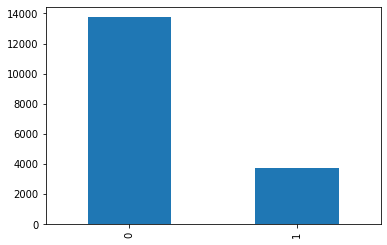

In [86]:
# データ数を取得
counts_loan_status = df["loan_status"].value_counts()

# 棒グラフの作成
counts_loan_status.plot(kind='bar')

# グラフの表示
plt.show()

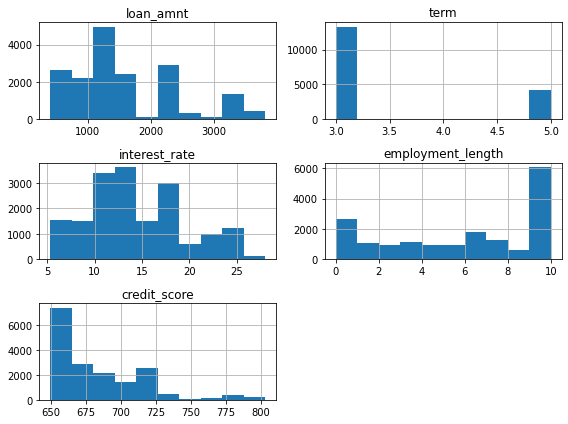

In [87]:
df_numeric.hist(figsize=(8, 6)) # df_numericは前処理で定義

# ラベルが重ならないように調整
plt.tight_layout()

# グラフの表示
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

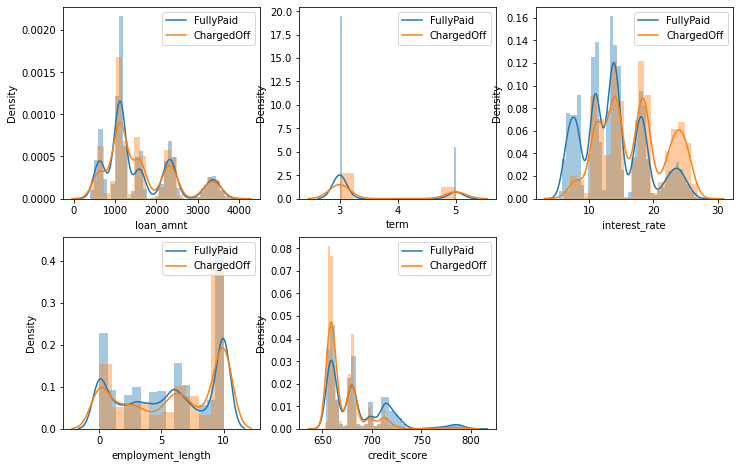

In [88]:
plt.figure(figsize=(12, 12))

for ncol, colname in enumerate(df_numeric.columns):
    plt.subplot(3, 3, ncol+1) # plt.subplot(縦のプロット数, 横のプロット数, プロット番号)
    sns.distplot(df_tmp.query("loan_status==0")[colname])
    sns.distplot(df_tmp.query("loan_status==1")[colname]) # 重ねる
    plt.legend(labels=["FullyPaid", "ChargedOff"], loc='upper right') # 凡例

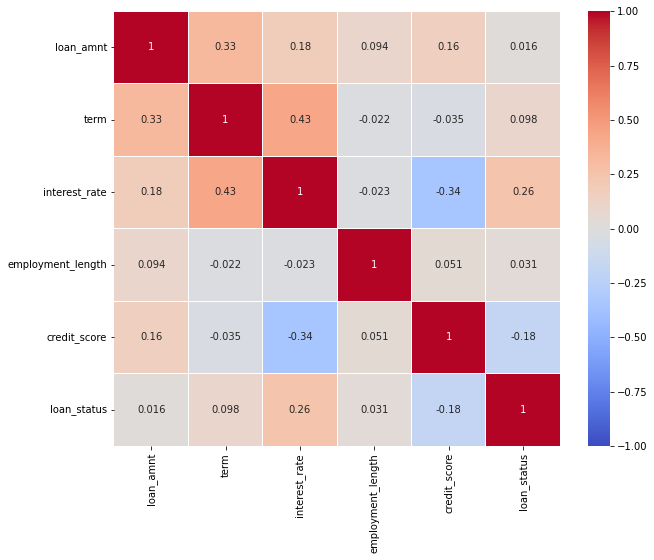

In [89]:
# グラフの整形
plt.figure(figsize=(10, 8))

# ヒートマップの作成
sns.heatmap(df.corr(), vmin=-1.0, vmax=1.0, annot=True,
            cmap='coolwarm', linewidths=0.1) # corr関数で相関関数を算出

In [90]:
# ダミー変数化
df = pd.get_dummies(
    df, columns=["grade", "purpose", "application_type"])

# 目的変数のデータフレーム
y = df["loan_status"]
# 説明変数のデータフレーム
X = df.drop(["loan_status"], axis=1)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

In [91]:
# モデルの初期化
lr = LogisticRegression()

# モデルの学習
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [92]:
# 混同行列の作成
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# 混同行列をデータフレーム化
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["実際のChargedOff", "実際のFullyPaid"], columns=["ChargedOffの予測", "FullyPaidの予測"])
print(df_cm)

# F1 Scoreの算出
f1 = f1_score(y_test, y_pred)
print(f1)

               ChargedOffの予測  FullyPaidの予測
実際のChargedOff            226          1289
実際のFullyPaid             165          5320
0.23714585519412382


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 12398 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 20104 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 28204 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 12398 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 20104 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 28204 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 23455 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotli

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

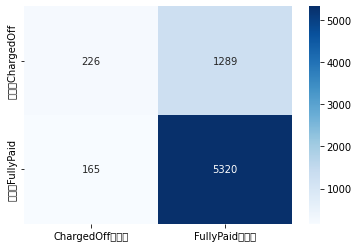

In [93]:
# heatmapによる混同行列の可視化
sns.heatmap(df_cm, annot=True, fmt="2g", cmap='Blues')
plt.yticks(va='center')

In [94]:
# 初期化
sampler = RandomUnderSampler(random_state=42)

# ダウンサンプリングの適用
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

# 返ってきたBoolを数値に変換
df["loan_status"] = df["loan_status"].replace(True, 0).replace(False, 1)
df["loan_status"] = df["loan_status"].astype(int)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [95]:
y_resampled.shape

(4488,)

In [96]:
# 学習
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)

# 予測
y_pred = lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [97]:
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["実際のChargedOff", "実際のFullyPaid"], columns=["ChargedOffの予測", "FullyPaidの予測"])
print(df_cm)

f1 = f1_score(y_test, y_pred)
print(f1)

               ChargedOffの予測  FullyPaidの予測
実際のChargedOff            226          1289
実際のFullyPaid             165          5320
0.4508215690812312


In [98]:
import time
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
# 乱数シード
seed = 42
# モデル作成
model = LGBMRegressor(boosting_type='gbdt', objective='binary',
                      random_state=seed, n_estimators=10000)  # チューニング前のモデル
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 100,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'auc',  # early_stopping_roundsの評価指標
              'eval_set': [(X_test, y_test)]  # early_stopping_roundsの評価指標算出用データ
              }
# クロスバリデーション
cv = KFold(n_splits=3, shuffle=True, random_state=seed)  # KFoldでクロスバリデーション分割指定

In [99]:
!pip install optuna

In [102]:
from sklearn.model_selection import cross_val_score
import lightgbm as lgb, numpy as np, optuna, sklearn.datasets, sklearn.metrics
import optuna
def objective(trial):
    param = {
        'objective': 'binary',
        'boosting_type': trial.suggest_categorical('hoge', ['gbdt', 'dart']),
        'num_leavrs': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }
    
    train_xy = lgb.Dataset(X_resampled, y_resampled)
    val_xy = lgb.Dataset(X_test, y_test, reference=train_xy)

    gbm = lgb.train(param, train_xy,valid_sets = val_xy)
    
    pred_proba = gbm.predict(X_test)
    pred = list(map(lambda x: 0 if x < 0.5 else 1, pred_proba))
    
    acc = sklearn.metrics.accuracy_score(y_test, pred)
    return acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-10-10 03:22:06,000] A new study created in memory with name: no-name-cb8416c1-de1e-4ecf-bd05-63bf21b1d3a3


[1]	valid_0's binary_logloss: 0.621726
[2]	valid_0's binary_logloss: 0.622868
[3]	valid_0's binary_logloss: 0.635342
[4]	valid_0's binary_logloss: 0.643306
[5]	valid_0's binary_logloss: 0.653269
[6]	valid_0's binary_logloss: 0.666684
[7]	valid_0's binary_logloss: 0.679457
[8]	valid_0's binary_logloss: 0.686238
[9]	valid_0's binary_logloss: 0.69726
[10]	valid_0's binary_logloss: 0.708971
[11]	valid_0's binary_logloss: 0.714127
[12]	valid_0's binary_logloss: 0.723305
[13]	valid_0's binary_logloss: 0.732764
[14]	valid_0's binary_logloss: 0.74502
[15]	valid_0's binary_logloss: 0.75482
[16]	valid_0's binary_logloss: 0.766617
[17]	valid_0's binary_logloss: 0.773147
[18]	valid_0's binary_logloss: 0.783602
[19]	valid_0's binary_logloss: 0.790151
[20]	valid_0's binary_logloss: 0.798076
[21]	valid_0's binary_logloss: 0.80687
[22]	valid_0's binary_logloss: 0.817129
[23]	valid_0's binary_logloss: 0.826723
[24]	valid_0's binary_logloss: 0.829389
[25]	valid_0's binary_logloss: 0.838754
[26]	valid_0'

[I 2021-10-10 03:22:06,262] Trial 0 finished with value: 0.6151428571428571 and parameters: {'hoge': 'gbdt', 'num_leaves': 23, 'learning_rate': 0.998382021335842}. Best is trial 0 with value: 0.6151428571428571.


[1]	valid_0's binary_logloss: 0.693146
[2]	valid_0's binary_logloss: 0.693144
[3]	valid_0's binary_logloss: 0.693143
[4]	valid_0's binary_logloss: 0.693141
[5]	valid_0's binary_logloss: 0.69314
[6]	valid_0's binary_logloss: 0.693139
[7]	valid_0's binary_logloss: 0.693137
[8]	valid_0's binary_logloss: 0.693136
[9]	valid_0's binary_logloss: 0.693134
[10]	valid_0's binary_logloss: 0.693133
[11]	valid_0's binary_logloss: 0.693131
[12]	valid_0's binary_logloss: 0.69313
[13]	valid_0's binary_logloss: 0.693129
[14]	valid_0's binary_logloss: 0.693127
[15]	valid_0's binary_logloss: 0.693126
[16]	valid_0's binary_logloss: 0.693124
[17]	valid_0's binary_logloss: 0.693123
[18]	valid_0's binary_logloss: 0.693121
[19]	valid_0's binary_logloss: 0.69312
[20]	valid_0's binary_logloss: 0.693119
[21]	valid_0's binary_logloss: 0.693117
[22]	valid_0's binary_logloss: 0.693116
[23]	valid_0's binary_logloss: 0.693114
[24]	valid_0's binary_logloss: 0.693113
[25]	valid_0's binary_logloss: 0.693111
[26]	valid_0

[I 2021-10-10 03:22:06,553] Trial 1 finished with value: 0.6195714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 75, 'learning_rate': 8.571103337261999e-06}. Best is trial 1 with value: 0.6195714285714286.



[92]	valid_0's binary_logloss: 0.693015
[93]	valid_0's binary_logloss: 0.693014
[94]	valid_0's binary_logloss: 0.693012
[95]	valid_0's binary_logloss: 0.693011
[96]	valid_0's binary_logloss: 0.69301
[97]	valid_0's binary_logloss: 0.693008
[98]	valid_0's binary_logloss: 0.693007
[99]	valid_0's binary_logloss: 0.693005
[100]	valid_0's binary_logloss: 0.693004
[1]	valid_0's binary_logloss: 0.693146
[2]	valid_0's binary_logloss: 0.693145
[3]	valid_0's binary_logloss: 0.693144
[4]	valid_0's binary_logloss: 0.693142
[5]	valid_0's binary_logloss: 0.693141
[6]	valid_0's binary_logloss: 0.69314
[7]	valid_0's binary_logloss: 0.693139
[8]	valid_0's binary_logloss: 0.693137
[9]	valid_0's binary_logloss: 0.693136
[10]	valid_0's binary_logloss: 0.693135
[11]	valid_0's binary_logloss: 0.693134
[12]	valid_0's binary_logloss: 0.693133
[13]	valid_0's binary_logloss: 0.693131
[14]	valid_0's binary_logloss: 0.69313
[15]	valid_0's binary_logloss: 0.693129
[16]	valid_0's binary_logloss: 0.693128
[17]	valid

[I 2021-10-10 03:22:06,852] Trial 2 finished with value: 0.6195714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 91, 'learning_rate': 7.270434011222035e-06}. Best is trial 1 with value: 0.6195714285714286.



[53]	valid_0's binary_logloss: 0.693083
[54]	valid_0's binary_logloss: 0.693082
[55]	valid_0's binary_logloss: 0.69308
[56]	valid_0's binary_logloss: 0.693079
[57]	valid_0's binary_logloss: 0.693078
[58]	valid_0's binary_logloss: 0.693077
[59]	valid_0's binary_logloss: 0.693075
[60]	valid_0's binary_logloss: 0.693074
[61]	valid_0's binary_logloss: 0.693073
[62]	valid_0's binary_logloss: 0.693072
[63]	valid_0's binary_logloss: 0.693071
[64]	valid_0's binary_logloss: 0.693069
[65]	valid_0's binary_logloss: 0.693068
[66]	valid_0's binary_logloss: 0.693067
[67]	valid_0's binary_logloss: 0.693066
[68]	valid_0's binary_logloss: 0.693065
[69]	valid_0's binary_logloss: 0.693063
[70]	valid_0's binary_logloss: 0.693062
[71]	valid_0's binary_logloss: 0.693061
[72]	valid_0's binary_logloss: 0.69306
[73]	valid_0's binary_logloss: 0.693058
[74]	valid_0's binary_logloss: 0.693057
[75]	valid_0's binary_logloss: 0.693056
[76]	valid_0's binary_logloss: 0.693055
[77]	valid_0's binary_logloss: 0.693054
[

[I 2021-10-10 03:22:07,134] Trial 3 finished with value: 0.6195714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 416, 'learning_rate': 8.873746841421532e-06}. Best is trial 1 with value: 0.6195714285714286.


[1]	valid_0's binary_logloss: 0.693147
[2]	valid_0's binary_logloss: 0.693147
[3]	valid_0's binary_logloss: 0.693147
[4]	valid_0's binary_logloss: 0.693147
[5]	valid_0's binary_logloss: 0.693147
[6]	valid_0's binary_logloss: 0.693147
[7]	valid_0's binary_logloss: 0.693147
[8]	valid_0's binary_logloss: 0.693147
[9]	valid_0's binary_logloss: 0.693147
[10]	valid_0's binary_logloss: 0.693147
[11]	valid_0's binary_logloss: 0.693147
[12]	valid_0's binary_logloss: 0.693147
[13]	valid_0's binary_logloss: 0.693147
[14]	valid_0's binary_logloss: 0.693147
[15]	valid_0's binary_logloss: 0.693147
[16]	valid_0's binary_logloss: 0.693147
[17]	valid_0's binary_logloss: 0.693147
[18]	valid_0's binary_logloss: 0.693147
[19]	valid_0's binary_logloss: 0.693147
[20]	valid_0's binary_logloss: 0.693147
[21]	valid_0's binary_logloss: 0.693147
[22]	valid_0's binary_logloss: 0.693147
[23]	valid_0's binary_logloss: 0.693147
[24]	valid_0's binary_logloss: 0.693147
[25]	valid_0's binary_logloss: 0.693147
[26]	vali

[I 2021-10-10 03:22:07,632] Trial 4 finished with value: 0.6195714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 889, 'learning_rate': 2.1059445219614874e-08}. Best is trial 1 with value: 0.6195714285714286.



[98]	valid_0's binary_logloss: 0.693147
[99]	valid_0's binary_logloss: 0.693147
[100]	valid_0's binary_logloss: 0.693147
[1]	valid_0's binary_logloss: 0.663046
[2]	valid_0's binary_logloss: 0.644257
[3]	valid_0's binary_logloss: 0.631392
[4]	valid_0's binary_logloss: 0.622135
[5]	valid_0's binary_logloss: 0.615913
[6]	valid_0's binary_logloss: 0.61265
[7]	valid_0's binary_logloss: 0.609765
[8]	valid_0's binary_logloss: 0.607078
[9]	valid_0's binary_logloss: 0.606143
[10]	valid_0's binary_logloss: 0.605145
[11]	valid_0's binary_logloss: 0.605632
[12]	valid_0's binary_logloss: 0.605482
[13]	valid_0's binary_logloss: 0.605414
[14]	valid_0's binary_logloss: 0.604727
[15]	valid_0's binary_logloss: 0.604649
[16]	valid_0's binary_logloss: 0.605573
[17]	valid_0's binary_logloss: 0.606148
[18]	valid_0's binary_logloss: 0.606475
[19]	valid_0's binary_logloss: 0.607487
[20]	valid_0's binary_logloss: 0.607885
[21]	valid_0's binary_logloss: 0.608858
[22]	valid_0's binary_logloss: 0.608982
[23]	val

[I 2021-10-10 03:22:07,892] Trial 5 finished with value: 0.6371428571428571 and parameters: {'hoge': 'gbdt', 'num_leaves': 185, 'learning_rate': 0.2059102372105935}. Best is trial 5 with value: 0.6371428571428571.


[67]	valid_0's binary_logloss: 0.644352
[68]	valid_0's binary_logloss: 0.645081
[69]	valid_0's binary_logloss: 0.645386
[70]	valid_0's binary_logloss: 0.64566
[71]	valid_0's binary_logloss: 0.646051
[72]	valid_0's binary_logloss: 0.6468
[73]	valid_0's binary_logloss: 0.647203
[74]	valid_0's binary_logloss: 0.647384
[75]	valid_0's binary_logloss: 0.648499
[76]	valid_0's binary_logloss: 0.649174
[77]	valid_0's binary_logloss: 0.649364
[78]	valid_0's binary_logloss: 0.64952
[79]	valid_0's binary_logloss: 0.649956
[80]	valid_0's binary_logloss: 0.649865
[81]	valid_0's binary_logloss: 0.650876
[82]	valid_0's binary_logloss: 0.651957
[83]	valid_0's binary_logloss: 0.653178
[84]	valid_0's binary_logloss: 0.653898
[85]	valid_0's binary_logloss: 0.654346
[86]	valid_0's binary_logloss: 0.654782
[87]	valid_0's binary_logloss: 0.655178
[88]	valid_0's binary_logloss: 0.656759
[89]	valid_0's binary_logloss: 0.657199
[90]	valid_0's binary_logloss: 0.657421
[91]	valid_0's binary_logloss: 0.658256
[92]

[I 2021-10-10 03:22:08,376] Trial 6 finished with value: 0.6195714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 323, 'learning_rate': 1.1443981411975178e-07}. Best is trial 5 with value: 0.6371428571428571.


[77]	valid_0's binary_logloss: 0.693146
[78]	valid_0's binary_logloss: 0.693146
[79]	valid_0's binary_logloss: 0.693146
[80]	valid_0's binary_logloss: 0.693146
[81]	valid_0's binary_logloss: 0.693146
[82]	valid_0's binary_logloss: 0.693146
[83]	valid_0's binary_logloss: 0.693146
[84]	valid_0's binary_logloss: 0.693146
[85]	valid_0's binary_logloss: 0.693146
[86]	valid_0's binary_logloss: 0.693146
[87]	valid_0's binary_logloss: 0.693146
[88]	valid_0's binary_logloss: 0.693146
[89]	valid_0's binary_logloss: 0.693146
[90]	valid_0's binary_logloss: 0.693146
[91]	valid_0's binary_logloss: 0.693146
[92]	valid_0's binary_logloss: 0.693146
[93]	valid_0's binary_logloss: 0.693146
[94]	valid_0's binary_logloss: 0.693146
[95]	valid_0's binary_logloss: 0.693146
[96]	valid_0's binary_logloss: 0.693146
[97]	valid_0's binary_logloss: 0.693146
[98]	valid_0's binary_logloss: 0.693146
[99]	valid_0's binary_logloss: 0.693146
[100]	valid_0's binary_logloss: 0.693146
[1]	valid_0's binary_logloss: 0.693133


[I 2021-10-10 03:22:08,862] Trial 7 finished with value: 0.6265714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 958, 'learning_rate': 8.536031355184301e-05}. Best is trial 5 with value: 0.6371428571428571.



[97]	valid_0's binary_logloss: 0.692542
[98]	valid_0's binary_logloss: 0.692547
[99]	valid_0's binary_logloss: 0.692533
[100]	valid_0's binary_logloss: 0.692519
[1]	valid_0's binary_logloss: 0.693113
[2]	valid_0's binary_logloss: 0.69308
[3]	valid_0's binary_logloss: 0.693046
[4]	valid_0's binary_logloss: 0.693012
[5]	valid_0's binary_logloss: 0.692978
[6]	valid_0's binary_logloss: 0.692945
[7]	valid_0's binary_logloss: 0.692911
[8]	valid_0's binary_logloss: 0.692922
[9]	valid_0's binary_logloss: 0.692888
[10]	valid_0's binary_logloss: 0.692854
[11]	valid_0's binary_logloss: 0.692821
[12]	valid_0's binary_logloss: 0.692832
[13]	valid_0's binary_logloss: 0.692798
[14]	valid_0's binary_logloss: 0.692765
[15]	valid_0's binary_logloss: 0.692731
[16]	valid_0's binary_logloss: 0.692697
[17]	valid_0's binary_logloss: 0.692663
[18]	valid_0's binary_logloss: 0.69263
[19]	valid_0's binary_logloss: 0.692596
[20]	valid_0's binary_logloss: 0.692562
[21]	valid_0's binary_logloss: 0.69257
[22]	valid

[I 2021-10-10 03:22:09,328] Trial 8 finished with value: 0.6265714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 270, 'learning_rate': 0.0002020371106682356}. Best is trial 5 with value: 0.6371428571428571.


[88]	valid_0's binary_logloss: 0.691739
[89]	valid_0's binary_logloss: 0.69175
[90]	valid_0's binary_logloss: 0.691767
[91]	valid_0's binary_logloss: 0.691781
[92]	valid_0's binary_logloss: 0.691749
[93]	valid_0's binary_logloss: 0.691715
[94]	valid_0's binary_logloss: 0.691733
[95]	valid_0's binary_logloss: 0.691746
[96]	valid_0's binary_logloss: 0.691759
[97]	valid_0's binary_logloss: 0.691726
[98]	valid_0's binary_logloss: 0.691738
[99]	valid_0's binary_logloss: 0.691705
[100]	valid_0's binary_logloss: 0.691672
[1]	valid_0's binary_logloss: 0.692949
[2]	valid_0's binary_logloss: 0.69275
[3]	valid_0's binary_logloss: 0.692552
[4]	valid_0's binary_logloss: 0.692354
[5]	valid_0's binary_logloss: 0.692158
[6]	valid_0's binary_logloss: 0.691964
[7]	valid_0's binary_logloss: 0.691769
[8]	valid_0's binary_logloss: 0.691573
[9]	valid_0's binary_logloss: 0.691381
[10]	valid_0's binary_logloss: 0.691187
[11]	valid_0's binary_logloss: 0.690992
[12]	valid_0's binary_logloss: 0.690799
[13]	valid

[I 2021-10-10 03:22:09,606] Trial 9 finished with value: 0.634 and parameters: {'hoge': 'gbdt', 'num_leaves': 63, 'learning_rate': 0.001187760316462808}. Best is trial 5 with value: 0.6371428571428571.



[34]	valid_0's binary_logloss: 0.686694
[35]	valid_0's binary_logloss: 0.686513
[36]	valid_0's binary_logloss: 0.686333
[37]	valid_0's binary_logloss: 0.686152
[38]	valid_0's binary_logloss: 0.685973
[39]	valid_0's binary_logloss: 0.685793
[40]	valid_0's binary_logloss: 0.685615
[41]	valid_0's binary_logloss: 0.685435
[42]	valid_0's binary_logloss: 0.685259
[43]	valid_0's binary_logloss: 0.685079
[44]	valid_0's binary_logloss: 0.684903
[45]	valid_0's binary_logloss: 0.684725
[46]	valid_0's binary_logloss: 0.68455
[47]	valid_0's binary_logloss: 0.684374
[48]	valid_0's binary_logloss: 0.684199
[49]	valid_0's binary_logloss: 0.684023
[50]	valid_0's binary_logloss: 0.683848
[51]	valid_0's binary_logloss: 0.683677
[52]	valid_0's binary_logloss: 0.683501
[53]	valid_0's binary_logloss: 0.683329
[54]	valid_0's binary_logloss: 0.683157
[55]	valid_0's binary_logloss: 0.682987
[56]	valid_0's binary_logloss: 0.682814
[57]	valid_0's binary_logloss: 0.682644
[58]	valid_0's binary_logloss: 0.682476


[I 2021-10-10 03:22:09,873] Trial 10 finished with value: 0.627 and parameters: {'hoge': 'gbdt', 'num_leaves': 647, 'learning_rate': 0.4536597227730547}. Best is trial 5 with value: 0.6371428571428571.


[1]	valid_0's binary_logloss: 0.691223
[2]	valid_0's binary_logloss: 0.689339
[3]	valid_0's binary_logloss: 0.687531
[4]	valid_0's binary_logloss: 0.685736
[5]	valid_0's binary_logloss: 0.684019
[6]	valid_0's binary_logloss: 0.682341
[7]	valid_0's binary_logloss: 0.6807
[8]	valid_0's binary_logloss: 0.67909
[9]	valid_0's binary_logloss: 0.677522
[10]	valid_0's binary_logloss: 0.675992
[11]	valid_0's binary_logloss: 0.674516
[12]	valid_0's binary_logloss: 0.67306
[13]	valid_0's binary_logloss: 0.671654
[14]	valid_0's binary_logloss: 0.670236
[15]	valid_0's binary_logloss: 0.668866
[16]	valid_0's binary_logloss: 0.6675
[17]	valid_0's binary_logloss: 0.666191
[18]	valid_0's binary_logloss: 0.6649
[19]	valid_0's binary_logloss: 0.663636
[20]	valid_0's binary_logloss: 0.662429
[21]	valid_0's binary_logloss: 0.661217
[22]	valid_0's binary_logloss: 0.660025
[23]	valid_0's binary_logloss: 0.658868
[24]	valid_0's binary_logloss: 0.657771
[25]	valid_0's binary_logloss: 0.656613
[26]	valid_0's bi

[I 2021-10-10 03:22:10,168] Trial 11 finished with value: 0.6394285714285715 and parameters: {'hoge': 'gbdt', 'num_leaves': 221, 'learning_rate': 0.011580032188102057}. Best is trial 11 with value: 0.6394285714285715.


[93]	valid_0's binary_logloss: 0.616751
[94]	valid_0's binary_logloss: 0.616483
[95]	valid_0's binary_logloss: 0.616253
[96]	valid_0's binary_logloss: 0.615942
[97]	valid_0's binary_logloss: 0.615655
[98]	valid_0's binary_logloss: 0.615428
[99]	valid_0's binary_logloss: 0.615168
[100]	valid_0's binary_logloss: 0.614955
[1]	valid_0's binary_logloss: 0.689701
[2]	valid_0's binary_logloss: 0.686435
[3]	valid_0's binary_logloss: 0.683332
[4]	valid_0's binary_logloss: 0.680339
[5]	valid_0's binary_logloss: 0.67748
[6]	valid_0's binary_logloss: 0.674776
[7]	valid_0's binary_logloss: 0.672147
[8]	valid_0's binary_logloss: 0.669663
[9]	valid_0's binary_logloss: 0.667231
[10]	valid_0's binary_logloss: 0.66487
[11]	valid_0's binary_logloss: 0.662582
[12]	valid_0's binary_logloss: 0.660428
[13]	valid_0's binary_logloss: 0.658335
[14]	valid_0's binary_logloss: 0.656388
[15]	valid_0's binary_logloss: 0.654375
[16]	valid_0's binary_logloss: 0.652607
[17]	valid_0's binary_logloss: 0.650873
[18]	valid

[I 2021-10-10 03:22:10,451] Trial 12 finished with value: 0.6441428571428571 and parameters: {'hoge': 'gbdt', 'num_leaves': 549, 'learning_rate': 0.020861648895239417}. Best is trial 12 with value: 0.6441428571428571.


[58]	valid_0's binary_logloss: 0.613917
[59]	valid_0's binary_logloss: 0.613479
[60]	valid_0's binary_logloss: 0.613112
[61]	valid_0's binary_logloss: 0.612693
[62]	valid_0's binary_logloss: 0.612317
[63]	valid_0's binary_logloss: 0.611928
[64]	valid_0's binary_logloss: 0.611538
[65]	valid_0's binary_logloss: 0.611217
[66]	valid_0's binary_logloss: 0.61104
[67]	valid_0's binary_logloss: 0.610727
[68]	valid_0's binary_logloss: 0.610565
[69]	valid_0's binary_logloss: 0.610278
[70]	valid_0's binary_logloss: 0.609926
[71]	valid_0's binary_logloss: 0.609545
[72]	valid_0's binary_logloss: 0.609332
[73]	valid_0's binary_logloss: 0.609061
[74]	valid_0's binary_logloss: 0.608896
[75]	valid_0's binary_logloss: 0.608675
[76]	valid_0's binary_logloss: 0.608512
[77]	valid_0's binary_logloss: 0.60826
[78]	valid_0's binary_logloss: 0.608104
[79]	valid_0's binary_logloss: 0.607938
[80]	valid_0's binary_logloss: 0.607706
[81]	valid_0's binary_logloss: 0.607586
[82]	valid_0's binary_logloss: 0.60747
[83

[I 2021-10-10 03:22:10,754] Trial 13 finished with value: 0.6417142857142857 and parameters: {'hoge': 'gbdt', 'num_leaves': 579, 'learning_rate': 0.015236523159519117}. Best is trial 12 with value: 0.6441428571428571.


[1]	valid_0's binary_logloss: 0.689703
[2]	valid_0's binary_logloss: 0.686438
[3]	valid_0's binary_logloss: 0.683337
[4]	valid_0's binary_logloss: 0.680345
[5]	valid_0's binary_logloss: 0.677487
[6]	valid_0's binary_logloss: 0.674785
[7]	valid_0's binary_logloss: 0.672157
[8]	valid_0's binary_logloss: 0.669674
[9]	valid_0's binary_logloss: 0.667243
[10]	valid_0's binary_logloss: 0.664883
[11]	valid_0's binary_logloss: 0.662595
[12]	valid_0's binary_logloss: 0.660442
[13]	valid_0's binary_logloss: 0.658349
[14]	valid_0's binary_logloss: 0.656403
[15]	valid_0's binary_logloss: 0.65439
[16]	valid_0's binary_logloss: 0.652623
[17]	valid_0's binary_logloss: 0.650889
[18]	valid_0's binary_logloss: 0.649118
[19]	valid_0's binary_logloss: 0.647498
[20]	valid_0's binary_logloss: 0.645929
[21]	valid_0's binary_logloss: 0.644418
[22]	valid_0's binary_logloss: 0.642987
[23]	valid_0's binary_logloss: 0.641452
[24]	valid_0's binary_logloss: 0.640068
[25]	valid_0's binary_logloss: 0.638725
[26]	valid

[I 2021-10-10 03:22:11,044] Trial 14 finished with value: 0.6412857142857142 and parameters: {'hoge': 'gbdt', 'num_leaves': 620, 'learning_rate': 0.02085024941784901}. Best is trial 12 with value: 0.6441428571428571.


[96]	valid_0's binary_logloss: 0.605789
[97]	valid_0's binary_logloss: 0.605766
[98]	valid_0's binary_logloss: 0.605735
[99]	valid_0's binary_logloss: 0.605633
[100]	valid_0's binary_logloss: 0.605455
[1]	valid_0's binary_logloss: 0.690664
[2]	valid_0's binary_logloss: 0.688279
[3]	valid_0's binary_logloss: 0.685971
[4]	valid_0's binary_logloss: 0.683715
[5]	valid_0's binary_logloss: 0.681565
[6]	valid_0's binary_logloss: 0.679489
[7]	valid_0's binary_logloss: 0.67746
[8]	valid_0's binary_logloss: 0.675493
[9]	valid_0's binary_logloss: 0.673575
[10]	valid_0's binary_logloss: 0.671731
[11]	valid_0's binary_logloss: 0.669916
[12]	valid_0's binary_logloss: 0.668167
[13]	valid_0's binary_logloss: 0.666428
[14]	valid_0's binary_logloss: 0.66482
[15]	valid_0's binary_logloss: 0.663171
[16]	valid_0's binary_logloss: 0.661586
[17]	valid_0's binary_logloss: 0.66004
[18]	valid_0's binary_logloss: 0.658594
[19]	valid_0's binary_logloss: 0.657141
[20]	valid_0's binary_logloss: 0.655795
[21]	valid_

[I 2021-10-10 03:22:11,332] Trial 15 finished with value: 0.6434285714285715 and parameters: {'hoge': 'gbdt', 'num_leaves': 573, 'learning_rate': 0.014981275489319218}. Best is trial 12 with value: 0.6441428571428571.



[54]	valid_0's binary_logloss: 0.624587
[55]	valid_0's binary_logloss: 0.624098
[56]	valid_0's binary_logloss: 0.623553
[57]	valid_0's binary_logloss: 0.622998
[58]	valid_0's binary_logloss: 0.622526
[59]	valid_0's binary_logloss: 0.62201
[60]	valid_0's binary_logloss: 0.621529
[61]	valid_0's binary_logloss: 0.62108
[62]	valid_0's binary_logloss: 0.620581
[63]	valid_0's binary_logloss: 0.620128
[64]	valid_0's binary_logloss: 0.619747
[65]	valid_0's binary_logloss: 0.619376
[66]	valid_0's binary_logloss: 0.618904
[67]	valid_0's binary_logloss: 0.618525
[68]	valid_0's binary_logloss: 0.618081
[69]	valid_0's binary_logloss: 0.617705
[70]	valid_0's binary_logloss: 0.617301
[71]	valid_0's binary_logloss: 0.616952
[72]	valid_0's binary_logloss: 0.616565
[73]	valid_0's binary_logloss: 0.616188
[74]	valid_0's binary_logloss: 0.615865
[75]	valid_0's binary_logloss: 0.615582
[76]	valid_0's binary_logloss: 0.615261
[77]	valid_0's binary_logloss: 0.614918
[78]	valid_0's binary_logloss: 0.614561
[

[I 2021-10-10 03:22:11,624] Trial 16 finished with value: 0.6341428571428571 and parameters: {'hoge': 'gbdt', 'num_leaves': 754, 'learning_rate': 0.0016177691338868597}. Best is trial 12 with value: 0.6441428571428571.


[1]	valid_0's binary_logloss: 0.681115
[2]	valid_0's binary_logloss: 0.671176
[3]	valid_0's binary_logloss: 0.662424
[4]	valid_0's binary_logloss: 0.654739
[5]	valid_0's binary_logloss: 0.648352
[6]	valid_0's binary_logloss: 0.642593
[7]	valid_0's binary_logloss: 0.637635
[8]	valid_0's binary_logloss: 0.633444
[9]	valid_0's binary_logloss: 0.629627
[10]	valid_0's binary_logloss: 0.62642
[11]	valid_0's binary_logloss: 0.623728
[12]	valid_0's binary_logloss: 0.621265
[13]	valid_0's binary_logloss: 0.618995
[14]	valid_0's binary_logloss: 0.617237
[15]	valid_0's binary_logloss: 0.615182
[16]	valid_0's binary_logloss: 0.613878
[17]	valid_0's binary_logloss: 0.612787
[18]	valid_0's binary_logloss: 0.611767
[19]	valid_0's binary_logloss: 0.610418
[20]	valid_0's binary_logloss: 0.609335
[21]	valid_0's binary_logloss: 0.608315
[22]	valid_0's binary_logloss: 0.607527
[23]	valid_0's binary_logloss: 0.606763
[24]	valid_0's binary_logloss: 0.606335
[25]	valid_0's binary_logloss: 0.605654
[26]	valid

[I 2021-10-10 03:22:11,968] Trial 17 finished with value: 0.6532857142857142 and parameters: {'hoge': 'gbdt', 'num_leaves': 470, 'learning_rate': 0.07540532714429976}. Best is trial 17 with value: 0.6532857142857142.


[85]	valid_0's binary_logloss: 0.610804
[86]	valid_0's binary_logloss: 0.610702
[87]	valid_0's binary_logloss: 0.611101
[88]	valid_0's binary_logloss: 0.611324
[89]	valid_0's binary_logloss: 0.611263
[90]	valid_0's binary_logloss: 0.611437
[91]	valid_0's binary_logloss: 0.611746
[92]	valid_0's binary_logloss: 0.611979
[93]	valid_0's binary_logloss: 0.612263
[94]	valid_0's binary_logloss: 0.612352
[95]	valid_0's binary_logloss: 0.612643
[96]	valid_0's binary_logloss: 0.613029
[97]	valid_0's binary_logloss: 0.61311
[98]	valid_0's binary_logloss: 0.613367
[99]	valid_0's binary_logloss: 0.613653
[100]	valid_0's binary_logloss: 0.614063
[1]	valid_0's binary_logloss: 0.677848
[2]	valid_0's binary_logloss: 0.665783
[3]	valid_0's binary_logloss: 0.655796
[4]	valid_0's binary_logloss: 0.647247
[5]	valid_0's binary_logloss: 0.640284
[6]	valid_0's binary_logloss: 0.634509
[7]	valid_0's binary_logloss: 0.629156
[8]	valid_0's binary_logloss: 0.631211
[9]	valid_0's binary_logloss: 0.626554
[10]	vali

[I 2021-10-10 03:22:12,509] Trial 18 finished with value: 0.6525714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 468, 'learning_rate': 0.09724912580440129}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.672174
[2]	valid_0's binary_logloss: 0.656675
[3]	valid_0's binary_logloss: 0.645013
[4]	valid_0's binary_logloss: 0.635724
[5]	valid_0's binary_logloss: 0.628488
[6]	valid_0's binary_logloss: 0.623065
[7]	valid_0's binary_logloss: 0.618941
[8]	valid_0's binary_logloss: 0.620923
[9]	valid_0's binary_logloss: 0.616554
[10]	valid_0's binary_logloss: 0.61339
[11]	valid_0's binary_logloss: 0.611025
[12]	valid_0's binary_logloss: 0.611926
[13]	valid_0's binary_logloss: 0.610821
[14]	valid_0's binary_logloss: 0.608686
[15]	valid_0's binary_logloss: 0.607442
[16]	valid_0's binary_logloss: 0.606761
[17]	valid_0's binary_logloss: 0.60585
[18]	valid_0's binary_logloss: 0.605258
[19]	valid_0's binary_logloss: 0.604521
[20]	valid_0's binary_logloss: 0.604463
[21]	valid_0's binary_logloss: 0.604232
[22]	valid_0's binary_logloss: 0.603773
[23]	valid_0's binary_logloss: 0.602684
[24]	valid_0's binary_logloss: 0.602612
[25]	valid_0's binary_logloss: 0.602745
[26]	valid_

[I 2021-10-10 03:22:13,010] Trial 19 finished with value: 0.6522857142857142 and parameters: {'hoge': 'dart', 'num_leaves': 428, 'learning_rate': 0.13685322195347782}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.693023
[2]	valid_0's binary_logloss: 0.6929
[3]	valid_0's binary_logloss: 0.692776
[4]	valid_0's binary_logloss: 0.692653
[5]	valid_0's binary_logloss: 0.69253
[6]	valid_0's binary_logloss: 0.692406
[7]	valid_0's binary_logloss: 0.692284
[8]	valid_0's binary_logloss: 0.692325
[9]	valid_0's binary_logloss: 0.692202
[10]	valid_0's binary_logloss: 0.69208
[11]	valid_0's binary_logloss: 0.691959
[12]	valid_0's binary_logloss: 0.692
[13]	valid_0's binary_logloss: 0.691878
[14]	valid_0's binary_logloss: 0.691758
[15]	valid_0's binary_logloss: 0.691636
[16]	valid_0's binary_logloss: 0.691514
[17]	valid_0's binary_logloss: 0.691395
[18]	valid_0's binary_logloss: 0.691274
[19]	valid_0's binary_logloss: 0.691153
[20]	valid_0's binary_logloss: 0.691033
[21]	valid_0's binary_logloss: 0.691059
[22]	valid_0's binary_logloss: 0.690941
[23]	valid_0's binary_logloss: 0.690821
[24]	valid_0's binary_logloss: 0.6907
[25]	valid_0's binary_logloss: 0.690582
[26]	valid_0's bin

[I 2021-10-10 03:22:13,510] Trial 20 finished with value: 0.6265714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 731, 'learning_rate': 0.0007395314823842951}. Best is trial 17 with value: 0.6532857142857142.


[98]	valid_0's binary_logloss: 0.688143
[99]	valid_0's binary_logloss: 0.688026
[100]	valid_0's binary_logloss: 0.687912
[1]	valid_0's binary_logloss: 0.675418
[2]	valid_0's binary_logloss: 0.661876
[3]	valid_0's binary_logloss: 0.650981
[4]	valid_0's binary_logloss: 0.641921
[5]	valid_0's binary_logloss: 0.63466
[6]	valid_0's binary_logloss: 0.628397
[7]	valid_0's binary_logloss: 0.624021
[8]	valid_0's binary_logloss: 0.625975
[9]	valid_0's binary_logloss: 0.621785
[10]	valid_0's binary_logloss: 0.618401
[11]	valid_0's binary_logloss: 0.615459
[12]	valid_0's binary_logloss: 0.616517
[13]	valid_0's binary_logloss: 0.614052
[14]	valid_0's binary_logloss: 0.612601
[15]	valid_0's binary_logloss: 0.611095
[16]	valid_0's binary_logloss: 0.60918
[17]	valid_0's binary_logloss: 0.60794
[18]	valid_0's binary_logloss: 0.607086
[19]	valid_0's binary_logloss: 0.606286
[20]	valid_0's binary_logloss: 0.605613
[21]	valid_0's binary_logloss: 0.605849
[22]	valid_0's binary_logloss: 0.604869
[23]	valid_

[I 2021-10-10 03:22:14,017] Trial 21 finished with value: 0.6477142857142857 and parameters: {'hoge': 'dart', 'num_leaves': 438, 'learning_rate': 0.11394142220216767}. Best is trial 17 with value: 0.6532857142857142.


[88]	valid_0's binary_logloss: 0.604856
[89]	valid_0's binary_logloss: 0.604732
[90]	valid_0's binary_logloss: 0.604628
[91]	valid_0's binary_logloss: 0.604527
[92]	valid_0's binary_logloss: 0.604937
[93]	valid_0's binary_logloss: 0.605291
[94]	valid_0's binary_logloss: 0.60508
[95]	valid_0's binary_logloss: 0.604874
[96]	valid_0's binary_logloss: 0.604664
[97]	valid_0's binary_logloss: 0.605023
[98]	valid_0's binary_logloss: 0.604802
[99]	valid_0's binary_logloss: 0.605699
[100]	valid_0's binary_logloss: 0.605802
[1]	valid_0's binary_logloss: 0.679052
[2]	valid_0's binary_logloss: 0.667764
[3]	valid_0's binary_logloss: 0.658078
[4]	valid_0's binary_logloss: 0.649919
[5]	valid_0's binary_logloss: 0.642956
[6]	valid_0's binary_logloss: 0.637119
[7]	valid_0's binary_logloss: 0.632215
[8]	valid_0's binary_logloss: 0.634342
[9]	valid_0's binary_logloss: 0.62975
[10]	valid_0's binary_logloss: 0.626317
[11]	valid_0's binary_logloss: 0.622746
[12]	valid_0's binary_logloss: 0.624112
[13]	valid

[I 2021-10-10 03:22:14,523] Trial 22 finished with value: 0.6461428571428571 and parameters: {'hoge': 'dart', 'num_leaves': 424, 'learning_rate': 0.08912774474001323}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.680141
[2]	valid_0's binary_logloss: 0.669556
[3]	valid_0's binary_logloss: 0.660501
[4]	valid_0's binary_logloss: 0.652594
[5]	valid_0's binary_logloss: 0.646045
[6]	valid_0's binary_logloss: 0.640202
[7]	valid_0's binary_logloss: 0.634906
[8]	valid_0's binary_logloss: 0.636927
[9]	valid_0's binary_logloss: 0.632252
[10]	valid_0's binary_logloss: 0.628457
[11]	valid_0's binary_logloss: 0.624975
[12]	valid_0's binary_logloss: 0.626345
[13]	valid_0's binary_logloss: 0.623203
[14]	valid_0's binary_logloss: 0.62051
[15]	valid_0's binary_logloss: 0.618331
[16]	valid_0's binary_logloss: 0.616104
[17]	valid_0's binary_logloss: 0.614041
[18]	valid_0's binary_logloss: 0.61262
[19]	valid_0's binary_logloss: 0.611308
[20]	valid_0's binary_logloss: 0.610136
[21]	valid_0's binary_logloss: 0.610572
[22]	valid_0's binary_logloss: 0.609224
[23]	valid_0's binary_logloss: 0.608593
[24]	valid_0's binary_logloss: 0.607588
[25]	valid_0's binary_logloss: 0.606836
[26]	valid_

[I 2021-10-10 03:22:15,041] Trial 23 finished with value: 0.6475714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 344, 'learning_rate': 0.08185397413975608}. Best is trial 17 with value: 0.6532857142857142.


[96]	valid_0's binary_logloss: 0.601858
[97]	valid_0's binary_logloss: 0.601792
[98]	valid_0's binary_logloss: 0.601863
[99]	valid_0's binary_logloss: 0.601887
[100]	valid_0's binary_logloss: 0.602097
[1]	valid_0's binary_logloss: 0.692346
[2]	valid_0's binary_logloss: 0.691549
[3]	valid_0's binary_logloss: 0.690775
[4]	valid_0's binary_logloss: 0.689999
[5]	valid_0's binary_logloss: 0.689236
[6]	valid_0's binary_logloss: 0.688473
[7]	valid_0's binary_logloss: 0.687726
[8]	valid_0's binary_logloss: 0.687984
[9]	valid_0's binary_logloss: 0.687237
[10]	valid_0's binary_logloss: 0.686505
[11]	valid_0's binary_logloss: 0.685775
[12]	valid_0's binary_logloss: 0.686018
[13]	valid_0's binary_logloss: 0.685302
[14]	valid_0's binary_logloss: 0.684579
[15]	valid_0's binary_logloss: 0.683878
[16]	valid_0's binary_logloss: 0.683172
[17]	valid_0's binary_logloss: 0.68248
[18]	valid_0's binary_logloss: 0.681793
[19]	valid_0's binary_logloss: 0.681115
[20]	valid_0's binary_logloss: 0.680436
[21]	vali

[I 2021-10-10 03:22:15,512] Trial 24 finished with value: 0.6368571428571429 and parameters: {'hoge': 'dart', 'num_leaves': 498, 'learning_rate': 0.004802880607733532}. Best is trial 17 with value: 0.6532857142857142.


[85]	valid_0's binary_logloss: 0.666969
[86]	valid_0's binary_logloss: 0.666438
[87]	valid_0's binary_logloss: 0.665898
[88]	valid_0's binary_logloss: 0.666235
[89]	valid_0's binary_logloss: 0.666419
[90]	valid_0's binary_logloss: 0.666707
[91]	valid_0's binary_logloss: 0.666957
[92]	valid_0's binary_logloss: 0.666424
[93]	valid_0's binary_logloss: 0.665885
[94]	valid_0's binary_logloss: 0.666175
[95]	valid_0's binary_logloss: 0.666388
[96]	valid_0's binary_logloss: 0.666613
[97]	valid_0's binary_logloss: 0.666094
[98]	valid_0's binary_logloss: 0.666318
[99]	valid_0's binary_logloss: 0.665788
[100]	valid_0's binary_logloss: 0.665262
[1]	valid_0's binary_logloss: 0.623085
[2]	valid_0's binary_logloss: 0.61567
[3]	valid_0's binary_logloss: 0.61629
[4]	valid_0's binary_logloss: 0.626502
[5]	valid_0's binary_logloss: 0.631532
[6]	valid_0's binary_logloss: 0.638255
[7]	valid_0's binary_logloss: 0.640806
[8]	valid_0's binary_logloss: 0.633973
[9]	valid_0's binary_logloss: 0.641193
[10]	valid

[I 2021-10-10 03:22:15,955] Trial 25 finished with value: 0.6295714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 703, 'learning_rate': 0.7550867263827864}. Best is trial 17 with value: 0.6532857142857142.


[81]	valid_0's binary_logloss: 0.751733
[82]	valid_0's binary_logloss: 0.756317
[83]	valid_0's binary_logloss: 0.753464
[84]	valid_0's binary_logloss: 0.749834
[85]	valid_0's binary_logloss: 0.745997
[86]	valid_0's binary_logloss: 0.751869
[87]	valid_0's binary_logloss: 0.75776
[88]	valid_0's binary_logloss: 0.752529
[89]	valid_0's binary_logloss: 0.750253
[90]	valid_0's binary_logloss: 0.746752
[91]	valid_0's binary_logloss: 0.74253
[92]	valid_0's binary_logloss: 0.746994
[93]	valid_0's binary_logloss: 0.752004
[94]	valid_0's binary_logloss: 0.748197
[95]	valid_0's binary_logloss: 0.745346
[96]	valid_0's binary_logloss: 0.743125
[97]	valid_0's binary_logloss: 0.747947
[98]	valid_0's binary_logloss: 0.743297
[99]	valid_0's binary_logloss: 0.749103
[100]	valid_0's binary_logloss: 0.754475
[1]	valid_0's binary_logloss: 0.683484
[2]	valid_0's binary_logloss: 0.675101
[3]	valid_0's binary_logloss: 0.667765
[4]	valid_0's binary_logloss: 0.66123
[5]	valid_0's binary_logloss: 0.655265
[6]	val

[I 2021-10-10 03:22:16,471] Trial 26 finished with value: 0.6454285714285715 and parameters: {'hoge': 'dart', 'num_leaves': 479, 'learning_rate': 0.0599639367398363}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.692616
[2]	valid_0's binary_logloss: 0.692086
[3]	valid_0's binary_logloss: 0.691562
[4]	valid_0's binary_logloss: 0.691048
[5]	valid_0's binary_logloss: 0.690529
[6]	valid_0's binary_logloss: 0.690016
[7]	valid_0's binary_logloss: 0.68951
[8]	valid_0's binary_logloss: 0.689683
[9]	valid_0's binary_logloss: 0.689176
[10]	valid_0's binary_logloss: 0.688678
[11]	valid_0's binary_logloss: 0.688175
[12]	valid_0's binary_logloss: 0.688345
[13]	valid_0's binary_logloss: 0.687849
[14]	valid_0's binary_logloss: 0.687354
[15]	valid_0's binary_logloss: 0.686866
[16]	valid_0's binary_logloss: 0.686379
[17]	valid_0's binary_logloss: 0.685898
[18]	valid_0's binary_logloss: 0.685417
[19]	valid_0's binary_logloss: 0.684942
[20]	valid_0's binary_logloss: 0.68447
[21]	valid_0's binary_logloss: 0.684578
[22]	valid_0's binary_logloss: 0.684111
[23]	valid_0's binary_logloss: 0.683639
[24]	valid_0's binary_logloss: 0.68318
[25]	valid_0's binary_logloss: 0.682717
[26]	valid_0

[I 2021-10-10 03:22:16,977] Trial 27 finished with value: 0.6342857142857142 and parameters: {'hoge': 'dart', 'num_leaves': 350, 'learning_rate': 0.0031818764553587487}. Best is trial 17 with value: 0.6532857142857142.


[98]	valid_0's binary_logloss: 0.674054
[99]	valid_0's binary_logloss: 0.673655
[100]	valid_0's binary_logloss: 0.673258
[1]	valid_0's binary_logloss: 0.693105
[2]	valid_0's binary_logloss: 0.693062
[3]	valid_0's binary_logloss: 0.69302
[4]	valid_0's binary_logloss: 0.692978
[5]	valid_0's binary_logloss: 0.692936
[6]	valid_0's binary_logloss: 0.692893
[7]	valid_0's binary_logloss: 0.692851
[8]	valid_0's binary_logloss: 0.692865
[9]	valid_0's binary_logloss: 0.692823
[10]	valid_0's binary_logloss: 0.69278
[11]	valid_0's binary_logloss: 0.692738
[12]	valid_0's binary_logloss: 0.692752
[13]	valid_0's binary_logloss: 0.69271
[14]	valid_0's binary_logloss: 0.692668
[15]	valid_0's binary_logloss: 0.692625
[16]	valid_0's binary_logloss: 0.692583
[17]	valid_0's binary_logloss: 0.692541
[18]	valid_0's binary_logloss: 0.692499
[19]	valid_0's binary_logloss: 0.692457
[20]	valid_0's binary_logloss: 0.692414
[21]	valid_0's binary_logloss: 0.692424
[22]	valid_0's binary_logloss: 0.692382
[23]	valid_

[I 2021-10-10 03:22:17,454] Trial 28 finished with value: 0.6265714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 811, 'learning_rate': 0.00025334426233805066}. Best is trial 17 with value: 0.6532857142857142.


[90]	valid_0's binary_logloss: 0.691422
[91]	valid_0's binary_logloss: 0.69144
[92]	valid_0's binary_logloss: 0.691398
[93]	valid_0's binary_logloss: 0.691357
[94]	valid_0's binary_logloss: 0.691379
[95]	valid_0's binary_logloss: 0.691395
[96]	valid_0's binary_logloss: 0.691411
[97]	valid_0's binary_logloss: 0.69137
[98]	valid_0's binary_logloss: 0.691386
[99]	valid_0's binary_logloss: 0.691344
[100]	valid_0's binary_logloss: 0.691303
[1]	valid_0's binary_logloss: 0.621295
[2]	valid_0's binary_logloss: 0.614669
[3]	valid_0's binary_logloss: 0.624988
[4]	valid_0's binary_logloss: 0.632357
[5]	valid_0's binary_logloss: 0.647166
[6]	valid_0's binary_logloss: 0.659791
[7]	valid_0's binary_logloss: 0.678296
[8]	valid_0's binary_logloss: 0.667296
[9]	valid_0's binary_logloss: 0.674905
[10]	valid_0's binary_logloss: 0.681509
[11]	valid_0's binary_logloss: 0.692045
[12]	valid_0's binary_logloss: 0.68353
[13]	valid_0's binary_logloss: 0.69081
[14]	valid_0's binary_logloss: 0.69617
[15]	valid_0'

[I 2021-10-10 03:22:17,896] Trial 29 finished with value: 0.6308571428571429 and parameters: {'hoge': 'dart', 'num_leaves': 159, 'learning_rate': 0.9480497283354218}. Best is trial 17 with value: 0.6532857142857142.


[85]	valid_0's binary_logloss: 0.802688
[86]	valid_0's binary_logloss: 0.8077
[87]	valid_0's binary_logloss: 0.810684
[88]	valid_0's binary_logloss: 0.806022
[89]	valid_0's binary_logloss: 0.80257
[90]	valid_0's binary_logloss: 0.797573
[91]	valid_0's binary_logloss: 0.792569
[92]	valid_0's binary_logloss: 0.798137
[93]	valid_0's binary_logloss: 0.80463
[94]	valid_0's binary_logloss: 0.800325
[95]	valid_0's binary_logloss: 0.796601
[96]	valid_0's binary_logloss: 0.793044
[97]	valid_0's binary_logloss: 0.802279
[98]	valid_0's binary_logloss: 0.798381
[99]	valid_0's binary_logloss: 0.805641
[100]	valid_0's binary_logloss: 0.812593
[1]	valid_0's binary_logloss: 0.660723
[2]	valid_0's binary_logloss: 0.640446
[3]	valid_0's binary_logloss: 0.62833
[4]	valid_0's binary_logloss: 0.620407
[5]	valid_0's binary_logloss: 0.61499
[6]	valid_0's binary_logloss: 0.611594
[7]	valid_0's binary_logloss: 0.608591
[8]	valid_0's binary_logloss: 0.60952
[9]	valid_0's binary_logloss: 0.608486
[10]	valid_0's 

[I 2021-10-10 03:22:18,372] Trial 30 finished with value: 0.6497142857142857 and parameters: {'hoge': 'dart', 'num_leaves': 393, 'learning_rate': 0.22474941869455461}. Best is trial 17 with value: 0.6532857142857142.


[80]	valid_0's binary_logloss: 0.616844
[81]	valid_0's binary_logloss: 0.616213
[82]	valid_0's binary_logloss: 0.616774
[83]	valid_0's binary_logloss: 0.61603
[84]	valid_0's binary_logloss: 0.615387
[85]	valid_0's binary_logloss: 0.61468
[86]	valid_0's binary_logloss: 0.61563
[87]	valid_0's binary_logloss: 0.616106
[88]	valid_0's binary_logloss: 0.615237
[89]	valid_0's binary_logloss: 0.6147
[90]	valid_0's binary_logloss: 0.61403
[91]	valid_0's binary_logloss: 0.61351
[92]	valid_0's binary_logloss: 0.614702
[93]	valid_0's binary_logloss: 0.61634
[94]	valid_0's binary_logloss: 0.615499
[95]	valid_0's binary_logloss: 0.615038
[96]	valid_0's binary_logloss: 0.614655
[97]	valid_0's binary_logloss: 0.616172
[98]	valid_0's binary_logloss: 0.615371
[99]	valid_0's binary_logloss: 0.616909
[100]	valid_0's binary_logloss: 0.61801
[1]	valid_0's binary_logloss: 0.659253
[2]	valid_0's binary_logloss: 0.638641
[3]	valid_0's binary_logloss: 0.626714
[4]	valid_0's binary_logloss: 0.619095
[5]	valid_0'

[I 2021-10-10 03:22:18,873] Trial 31 finished with value: 0.6468571428571429 and parameters: {'hoge': 'dart', 'num_leaves': 402, 'learning_rate': 0.23698480617741832}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.684988
[2]	valid_0's binary_logloss: 0.677756
[3]	valid_0's binary_logloss: 0.671306
[4]	valid_0's binary_logloss: 0.665422
[5]	valid_0's binary_logloss: 0.659912
[6]	valid_0's binary_logloss: 0.655233
[7]	valid_0's binary_logloss: 0.650785
[8]	valid_0's binary_logloss: 0.652505
[9]	valid_0's binary_logloss: 0.648374
[10]	valid_0's binary_logloss: 0.644634
[11]	valid_0's binary_logloss: 0.641138
[12]	valid_0's binary_logloss: 0.642468
[13]	valid_0's binary_logloss: 0.639049
[14]	valid_0's binary_logloss: 0.63592
[15]	valid_0's binary_logloss: 0.633248
[16]	valid_0's binary_logloss: 0.630683
[17]	valid_0's binary_logloss: 0.62846
[18]	valid_0's binary_logloss: 0.626426
[19]	valid_0's binary_logloss: 0.624432
[20]	valid_0's binary_logloss: 0.622574
[21]	valid_0's binary_logloss: 0.623182
[22]	valid_0's binary_logloss: 0.621308
[23]	valid_0's binary_logloss: 0.619796
[24]	valid_0's binary_logloss: 0.618662
[25]	valid_0's binary_logloss: 0.617289
[26]	valid_

[I 2021-10-10 03:22:19,374] Trial 32 finished with value: 0.6452857142857142 and parameters: {'hoge': 'dart', 'num_leaves': 514, 'learning_rate': 0.05031878029098571}. Best is trial 17 with value: 0.6532857142857142.



[1]	valid_0's binary_logloss: 0.636603
[2]	valid_0's binary_logloss: 0.617508
[3]	valid_0's binary_logloss: 0.613814
[4]	valid_0's binary_logloss: 0.61387
[5]	valid_0's binary_logloss: 0.612807
[6]	valid_0's binary_logloss: 0.613623
[7]	valid_0's binary_logloss: 0.612759
[8]	valid_0's binary_logloss: 0.610931
[9]	valid_0's binary_logloss: 0.61341
[10]	valid_0's binary_logloss: 0.616214
[11]	valid_0's binary_logloss: 0.619632
[12]	valid_0's binary_logloss: 0.617846
[13]	valid_0's binary_logloss: 0.622419
[14]	valid_0's binary_logloss: 0.623902
[15]	valid_0's binary_logloss: 0.626584
[16]	valid_0's binary_logloss: 0.629599
[17]	valid_0's binary_logloss: 0.632647
[18]	valid_0's binary_logloss: 0.635776
[19]	valid_0's binary_logloss: 0.637875
[20]	valid_0's binary_logloss: 0.641089
[21]	valid_0's binary_logloss: 0.639726
[22]	valid_0's binary_logloss: 0.642349
[23]	valid_0's binary_logloss: 0.643878
[24]	valid_0's binary_logloss: 0.644069
[25]	valid_0's binary_logloss: 0.647384
[26]	valid

[I 2021-10-10 03:22:19,821] Trial 33 finished with value: 0.6342857142857142 and parameters: {'hoge': 'dart', 'num_leaves': 282, 'learning_rate': 0.4736375230260374}. Best is trial 17 with value: 0.6532857142857142.


[91]	valid_0's binary_logloss: 0.664098
[92]	valid_0's binary_logloss: 0.666234
[93]	valid_0's binary_logloss: 0.668335
[94]	valid_0's binary_logloss: 0.666512
[95]	valid_0's binary_logloss: 0.665193
[96]	valid_0's binary_logloss: 0.664174
[97]	valid_0's binary_logloss: 0.668137
[98]	valid_0's binary_logloss: 0.666306
[99]	valid_0's binary_logloss: 0.667491
[100]	valid_0's binary_logloss: 0.668691
[1]	valid_0's binary_logloss: 0.693142
[2]	valid_0's binary_logloss: 0.693137
[3]	valid_0's binary_logloss: 0.693132
[4]	valid_0's binary_logloss: 0.693127
[5]	valid_0's binary_logloss: 0.693122
[6]	valid_0's binary_logloss: 0.693117
[7]	valid_0's binary_logloss: 0.693112
[8]	valid_0's binary_logloss: 0.693113
[9]	valid_0's binary_logloss: 0.693108
[10]	valid_0's binary_logloss: 0.693103
[11]	valid_0's binary_logloss: 0.693098
[12]	valid_0's binary_logloss: 0.6931
[13]	valid_0's binary_logloss: 0.693095
[14]	valid_0's binary_logloss: 0.69309
[15]	valid_0's binary_logloss: 0.693084
[16]	valid_

[I 2021-10-10 03:22:20,314] Trial 34 finished with value: 0.6195714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 354, 'learning_rate': 3.0398452086550314e-05}. Best is trial 17 with value: 0.6532857142857142.



[82]	valid_0's binary_logloss: 0.692933
[83]	valid_0's binary_logloss: 0.692935
[84]	valid_0's binary_logloss: 0.692938
[85]	valid_0's binary_logloss: 0.692941
[86]	valid_0's binary_logloss: 0.692936
[87]	valid_0's binary_logloss: 0.69293
[88]	valid_0's binary_logloss: 0.692933
[89]	valid_0's binary_logloss: 0.692935
[90]	valid_0's binary_logloss: 0.692938
[91]	valid_0's binary_logloss: 0.69294
[92]	valid_0's binary_logloss: 0.692935
[93]	valid_0's binary_logloss: 0.69293
[94]	valid_0's binary_logloss: 0.692932
[95]	valid_0's binary_logloss: 0.692934
[96]	valid_0's binary_logloss: 0.692936
[97]	valid_0's binary_logloss: 0.692931
[98]	valid_0's binary_logloss: 0.692933
[99]	valid_0's binary_logloss: 0.692928
[100]	valid_0's binary_logloss: 0.692923
[1]	valid_0's binary_logloss: 0.693147
[2]	valid_0's binary_logloss: 0.693147
[3]	valid_0's binary_logloss: 0.693147
[4]	valid_0's binary_logloss: 0.693147
[5]	valid_0's binary_logloss: 0.693147
[6]	valid_0's binary_logloss: 0.693146
[7]	val

[I 2021-10-10 03:22:20,820] Trial 35 finished with value: 0.6195714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 474, 'learning_rate': 7.42966538413502e-07}. Best is trial 17 with value: 0.6532857142857142.


[98]	valid_0's binary_logloss: 0.693142
[99]	valid_0's binary_logloss: 0.693142
[100]	valid_0's binary_logloss: 0.693142
[1]	valid_0's binary_logloss: 0.665844
[2]	valid_0's binary_logloss: 0.647673
[3]	valid_0's binary_logloss: 0.634674
[4]	valid_0's binary_logloss: 0.625365
[5]	valid_0's binary_logloss: 0.61853
[6]	valid_0's binary_logloss: 0.61468
[7]	valid_0's binary_logloss: 0.612166
[8]	valid_0's binary_logloss: 0.613401
[9]	valid_0's binary_logloss: 0.609376
[10]	valid_0's binary_logloss: 0.60741
[11]	valid_0's binary_logloss: 0.606788
[12]	valid_0's binary_logloss: 0.606725
[13]	valid_0's binary_logloss: 0.6053
[14]	valid_0's binary_logloss: 0.60514
[15]	valid_0's binary_logloss: 0.60475
[16]	valid_0's binary_logloss: 0.603448
[17]	valid_0's binary_logloss: 0.60302
[18]	valid_0's binary_logloss: 0.603166
[19]	valid_0's binary_logloss: 0.603124
[20]	valid_0's binary_logloss: 0.602473
[21]	valid_0's binary_logloss: 0.602584
[22]	valid_0's binary_logloss: 0.603107
[23]	valid_0's b

[I 2021-10-10 03:22:21,317] Trial 36 finished with value: 0.6501428571428571 and parameters: {'hoge': 'dart', 'num_leaves': 396, 'learning_rate': 0.183949488073869}. Best is trial 17 with value: 0.6532857142857142.



[89]	valid_0's binary_logloss: 0.610514
[90]	valid_0's binary_logloss: 0.609992
[91]	valid_0's binary_logloss: 0.609545
[92]	valid_0's binary_logloss: 0.609738
[93]	valid_0's binary_logloss: 0.610708
[94]	valid_0's binary_logloss: 0.610213
[95]	valid_0's binary_logloss: 0.609902
[96]	valid_0's binary_logloss: 0.609521
[97]	valid_0's binary_logloss: 0.610105
[98]	valid_0's binary_logloss: 0.609758
[99]	valid_0's binary_logloss: 0.609542
[100]	valid_0's binary_logloss: 0.609593
[1]	valid_0's binary_logloss: 0.692115
[2]	valid_0's binary_logloss: 0.691092
[3]	valid_0's binary_logloss: 0.6901
[4]	valid_0's binary_logloss: 0.689113
[5]	valid_0's binary_logloss: 0.688141
[6]	valid_0's binary_logloss: 0.687175
[7]	valid_0's binary_logloss: 0.686225
[8]	valid_0's binary_logloss: 0.685285
[9]	valid_0's binary_logloss: 0.68437
[10]	valid_0's binary_logloss: 0.683459
[11]	valid_0's binary_logloss: 0.682554
[12]	valid_0's binary_logloss: 0.681671
[13]	valid_0's binary_logloss: 0.680794
[14]	valid

[I 2021-10-10 03:22:21,625] Trial 37 finished with value: 0.641 and parameters: {'hoge': 'gbdt', 'num_leaves': 271, 'learning_rate': 0.006192990278651988}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.685055
[2]	valid_0's binary_logloss: 0.677875
[3]	valid_0's binary_logloss: 0.671465
[4]	valid_0's binary_logloss: 0.665614
[5]	valid_0's binary_logloss: 0.66032
[6]	valid_0's binary_logloss: 0.655451
[7]	valid_0's binary_logloss: 0.651175
[8]	valid_0's binary_logloss: 0.652888
[9]	valid_0's binary_logloss: 0.648623
[10]	valid_0's binary_logloss: 0.644883
[11]	valid_0's binary_logloss: 0.641225
[12]	valid_0's binary_logloss: 0.64254
[13]	valid_0's binary_logloss: 0.639065
[14]	valid_0's binary_logloss: 0.63604
[15]	valid_0's binary_logloss: 0.633297
[16]	valid_0's binary_logloss: 0.630862
[17]	valid_0's binary_logloss: 0.628522
[18]	valid_0's binary_logloss: 0.626442
[19]	valid_0's binary_logloss: 0.624709
[20]	valid_0's binary_logloss: 0.622903
[21]	valid_0's binary_logloss: 0.623471
[22]	valid_0's binary_logloss: 0.622037
[23]	valid_0's binary_logloss: 0.620446
[24]	valid_0's binary_logloss: 0.6191
[25]	valid_0's binary_logloss: 0.617694
[26]	valid_0's

[I 2021-10-10 03:22:22,148] Trial 38 finished with value: 0.642 and parameters: {'hoge': 'dart', 'num_leaves': 532, 'learning_rate': 0.049895630706658575}. Best is trial 17 with value: 0.6532857142857142.


[95]	valid_0's binary_logloss: 0.606153
[96]	valid_0's binary_logloss: 0.606362
[97]	valid_0's binary_logloss: 0.606018
[98]	valid_0's binary_logloss: 0.606262
[99]	valid_0's binary_logloss: 0.606046
[100]	valid_0's binary_logloss: 0.605531
[1]	valid_0's binary_logloss: 0.693147
[2]	valid_0's binary_logloss: 0.693147
[3]	valid_0's binary_logloss: 0.693146
[4]	valid_0's binary_logloss: 0.693146
[5]	valid_0's binary_logloss: 0.693146
[6]	valid_0's binary_logloss: 0.693146
[7]	valid_0's binary_logloss: 0.693146
[8]	valid_0's binary_logloss: 0.693145
[9]	valid_0's binary_logloss: 0.693145
[10]	valid_0's binary_logloss: 0.693145
[11]	valid_0's binary_logloss: 0.693145
[12]	valid_0's binary_logloss: 0.693144
[13]	valid_0's binary_logloss: 0.693144
[14]	valid_0's binary_logloss: 0.693144
[15]	valid_0's binary_logloss: 0.693144
[16]	valid_0's binary_logloss: 0.693143
[17]	valid_0's binary_logloss: 0.693143
[18]	valid_0's binary_logloss: 0.693143
[19]	valid_0's binary_logloss: 0.693143
[20]	val

[I 2021-10-10 03:22:22,429] Trial 39 finished with value: 0.6195714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 643, 'learning_rate': 1.421066721363353e-06}. Best is trial 17 with value: 0.6532857142857142.


[48]	valid_0's binary_logloss: 0.693136
[49]	valid_0's binary_logloss: 0.693136
[50]	valid_0's binary_logloss: 0.693135
[51]	valid_0's binary_logloss: 0.693135
[52]	valid_0's binary_logloss: 0.693135
[53]	valid_0's binary_logloss: 0.693135
[54]	valid_0's binary_logloss: 0.693134
[55]	valid_0's binary_logloss: 0.693134
[56]	valid_0's binary_logloss: 0.693134
[57]	valid_0's binary_logloss: 0.693134
[58]	valid_0's binary_logloss: 0.693133
[59]	valid_0's binary_logloss: 0.693133
[60]	valid_0's binary_logloss: 0.693133
[61]	valid_0's binary_logloss: 0.693133
[62]	valid_0's binary_logloss: 0.693132
[63]	valid_0's binary_logloss: 0.693132
[64]	valid_0's binary_logloss: 0.693132
[65]	valid_0's binary_logloss: 0.693132
[66]	valid_0's binary_logloss: 0.693131
[67]	valid_0's binary_logloss: 0.693131
[68]	valid_0's binary_logloss: 0.693131
[69]	valid_0's binary_logloss: 0.693131
[70]	valid_0's binary_logloss: 0.693131
[71]	valid_0's binary_logloss: 0.69313
[72]	valid_0's binary_logloss: 0.69313
[7

[I 2021-10-10 03:22:22,912] Trial 40 finished with value: 0.6445714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 458, 'learning_rate': 0.2477903243537778}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.660558
[2]	valid_0's binary_logloss: 0.64024
[3]	valid_0's binary_logloss: 0.628138
[4]	valid_0's binary_logloss: 0.620073
[5]	valid_0's binary_logloss: 0.615452
[6]	valid_0's binary_logloss: 0.613022
[7]	valid_0's binary_logloss: 0.611463
[8]	valid_0's binary_logloss: 0.611794
[9]	valid_0's binary_logloss: 0.608857
[10]	valid_0's binary_logloss: 0.608426
[11]	valid_0's binary_logloss: 0.608272
[12]	valid_0's binary_logloss: 0.607832
[13]	valid_0's binary_logloss: 0.606998
[14]	valid_0's binary_logloss: 0.606198
[15]	valid_0's binary_logloss: 0.607047
[16]	valid_0's binary_logloss: 0.606821
[17]	valid_0's binary_logloss: 0.606735
[18]	valid_0's binary_logloss: 0.607458
[19]	valid_0's binary_logloss: 0.608471
[20]	valid_0's binary_logloss: 0.608603
[21]	valid_0's binary_logloss: 0.607998
[22]	valid_0's binary_logloss: 0.608248
[23]	valid_0's binary_logloss: 0.608877
[24]	valid_0's binary_logloss: 0.608982
[25]	valid_0's binary_logloss: 0.610188
[26]	valid

[I 2021-10-10 03:22:23,375] Trial 41 finished with value: 0.6445714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 388, 'learning_rate': 0.22611191770985528}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.68809
[2]	valid_0's binary_logloss: 0.683393
[3]	valid_0's binary_logloss: 0.679005
[4]	valid_0's binary_logloss: 0.674951
[5]	valid_0's binary_logloss: 0.671086
[6]	valid_0's binary_logloss: 0.667374
[7]	valid_0's binary_logloss: 0.664018
[8]	valid_0's binary_logloss: 0.665325
[9]	valid_0's binary_logloss: 0.662016
[10]	valid_0's binary_logloss: 0.658838
[11]	valid_0's binary_logloss: 0.655974
[12]	valid_0's binary_logloss: 0.656979
[13]	valid_0's binary_logloss: 0.654113
[14]	valid_0's binary_logloss: 0.651506
[15]	valid_0's binary_logloss: 0.648918
[16]	valid_0's binary_logloss: 0.646462
[17]	valid_0's binary_logloss: 0.644206
[18]	valid_0's binary_logloss: 0.642027
[19]	valid_0's binary_logloss: 0.639918
[20]	valid_0's binary_logloss: 0.637975
[21]	valid_0's binary_logloss: 0.638504
[22]	valid_0's binary_logloss: 0.636569
[23]	valid_0's binary_logloss: 0.634765
[24]	valid_0's binary_logloss: 0.633116
[25]	valid_0's binary_logloss: 0.631618
[26]	valid

[I 2021-10-10 03:22:23,917] Trial 42 finished with value: 0.6388571428571429 and parameters: {'hoge': 'dart', 'num_leaves': 296, 'learning_rate': 0.0308077922225965}. Best is trial 17 with value: 0.6532857142857142.


[94]	valid_0's binary_logloss: 0.614601
[95]	valid_0's binary_logloss: 0.614932
[96]	valid_0's binary_logloss: 0.615239
[97]	valid_0's binary_logloss: 0.614555
[98]	valid_0's binary_logloss: 0.614896
[99]	valid_0's binary_logloss: 0.614354
[100]	valid_0's binary_logloss: 0.613749
[1]	valid_0's binary_logloss: 0.66757
[2]	valid_0's binary_logloss: 0.650369
[3]	valid_0's binary_logloss: 0.637488
[4]	valid_0's binary_logloss: 0.628079
[5]	valid_0's binary_logloss: 0.622072
[6]	valid_0's binary_logloss: 0.616722
[7]	valid_0's binary_logloss: 0.613321
[8]	valid_0's binary_logloss: 0.614608
[9]	valid_0's binary_logloss: 0.612158
[10]	valid_0's binary_logloss: 0.609458
[11]	valid_0's binary_logloss: 0.607196
[12]	valid_0's binary_logloss: 0.60763
[13]	valid_0's binary_logloss: 0.605586
[14]	valid_0's binary_logloss: 0.604749
[15]	valid_0's binary_logloss: 0.604399
[16]	valid_0's binary_logloss: 0.604549
[17]	valid_0's binary_logloss: 0.603778
[18]	valid_0's binary_logloss: 0.602883
[19]	valid

[I 2021-10-10 03:22:24,408] Trial 43 finished with value: 0.6498571428571429 and parameters: {'hoge': 'dart', 'num_leaves': 389, 'learning_rate': 0.17076892674234617}. Best is trial 17 with value: 0.6532857142857142.


[85]	valid_0's binary_logloss: 0.607411
[86]	valid_0's binary_logloss: 0.608213
[87]	valid_0's binary_logloss: 0.609079
[88]	valid_0's binary_logloss: 0.608604
[89]	valid_0's binary_logloss: 0.608107
[90]	valid_0's binary_logloss: 0.607855
[91]	valid_0's binary_logloss: 0.60742
[92]	valid_0's binary_logloss: 0.608224
[93]	valid_0's binary_logloss: 0.60947
[94]	valid_0's binary_logloss: 0.609211
[95]	valid_0's binary_logloss: 0.608925
[96]	valid_0's binary_logloss: 0.608569
[97]	valid_0's binary_logloss: 0.609131
[98]	valid_0's binary_logloss: 0.608745
[99]	valid_0's binary_logloss: 0.609178
[100]	valid_0's binary_logloss: 0.609754
[1]	valid_0's binary_logloss: 0.674966
[2]	valid_0's binary_logloss: 0.661178
[3]	valid_0's binary_logloss: 0.650153
[4]	valid_0's binary_logloss: 0.641039
[5]	valid_0's binary_logloss: 0.633776
[6]	valid_0's binary_logloss: 0.627456
[7]	valid_0's binary_logloss: 0.623005
[8]	valid_0's binary_logloss: 0.624951
[9]	valid_0's binary_logloss: 0.620861
[10]	valid

[I 2021-10-10 03:22:24,913] Trial 44 finished with value: 0.6511428571428571 and parameters: {'hoge': 'dart', 'num_leaves': 201, 'learning_rate': 0.11709100689844501}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.691903
[2]	valid_0's binary_logloss: 0.690673
[3]	valid_0's binary_logloss: 0.689485
[4]	valid_0's binary_logloss: 0.688305
[5]	valid_0's binary_logloss: 0.687141
[6]	valid_0's binary_logloss: 0.685992
[7]	valid_0's binary_logloss: 0.68487
[8]	valid_0's binary_logloss: 0.68526
[9]	valid_0's binary_logloss: 0.684138
[10]	valid_0's binary_logloss: 0.683052
[11]	valid_0's binary_logloss: 0.681988
[12]	valid_0's binary_logloss: 0.682355
[13]	valid_0's binary_logloss: 0.681288
[14]	valid_0's binary_logloss: 0.680254
[15]	valid_0's binary_logloss: 0.679212
[16]	valid_0's binary_logloss: 0.678204
[17]	valid_0's binary_logloss: 0.677208
[18]	valid_0's binary_logloss: 0.676224
[19]	valid_0's binary_logloss: 0.675237
[20]	valid_0's binary_logloss: 0.674294
[21]	valid_0's binary_logloss: 0.674523
[22]	valid_0's binary_logloss: 0.673576
[23]	valid_0's binary_logloss: 0.672657
[24]	valid_0's binary_logloss: 0.671737
[25]	valid_0's binary_logloss: 0.670827
[26]	valid_

[I 2021-10-10 03:22:25,435] Trial 45 finished with value: 0.631 and parameters: {'hoge': 'dart', 'num_leaves': 114, 'learning_rate': 0.007469384072777325}. Best is trial 17 with value: 0.6532857142857142.


[96]	valid_0's binary_logloss: 0.655977
[97]	valid_0's binary_logloss: 0.655291
[98]	valid_0's binary_logloss: 0.655587
[99]	valid_0's binary_logloss: 0.65491
[100]	valid_0's binary_logloss: 0.654246
[1]	valid_0's binary_logloss: 0.634794
[2]	valid_0's binary_logloss: 0.616672
[3]	valid_0's binary_logloss: 0.612301
[4]	valid_0's binary_logloss: 0.611975
[5]	valid_0's binary_logloss: 0.613045
[6]	valid_0's binary_logloss: 0.617928
[7]	valid_0's binary_logloss: 0.619271
[8]	valid_0's binary_logloss: 0.622412
[9]	valid_0's binary_logloss: 0.625468
[10]	valid_0's binary_logloss: 0.630722
[11]	valid_0's binary_logloss: 0.635323
[12]	valid_0's binary_logloss: 0.637306
[13]	valid_0's binary_logloss: 0.640689
[14]	valid_0's binary_logloss: 0.644066
[15]	valid_0's binary_logloss: 0.645536
[16]	valid_0's binary_logloss: 0.647752
[17]	valid_0's binary_logloss: 0.650186
[18]	valid_0's binary_logloss: 0.652513
[19]	valid_0's binary_logloss: 0.65363
[20]	valid_0's binary_logloss: 0.656541
[21]	valid

[I 2021-10-10 03:22:25,695] Trial 46 finished with value: 0.6271428571428571 and parameters: {'hoge': 'gbdt', 'num_leaves': 220, 'learning_rate': 0.4992280923394884}. Best is trial 17 with value: 0.6532857142857142.


[64]	valid_0's binary_logloss: 0.752074
[65]	valid_0's binary_logloss: 0.752939
[66]	valid_0's binary_logloss: 0.753775
[67]	valid_0's binary_logloss: 0.757404
[68]	valid_0's binary_logloss: 0.759772
[69]	valid_0's binary_logloss: 0.760803
[70]	valid_0's binary_logloss: 0.763796
[71]	valid_0's binary_logloss: 0.764895
[72]	valid_0's binary_logloss: 0.765897
[73]	valid_0's binary_logloss: 0.76712
[74]	valid_0's binary_logloss: 0.769633
[75]	valid_0's binary_logloss: 0.771801
[76]	valid_0's binary_logloss: 0.772783
[77]	valid_0's binary_logloss: 0.775148
[78]	valid_0's binary_logloss: 0.779155
[79]	valid_0's binary_logloss: 0.781215
[80]	valid_0's binary_logloss: 0.784409
[81]	valid_0's binary_logloss: 0.785319
[82]	valid_0's binary_logloss: 0.786388
[83]	valid_0's binary_logloss: 0.787025
[84]	valid_0's binary_logloss: 0.789868
[85]	valid_0's binary_logloss: 0.792157
[86]	valid_0's binary_logloss: 0.793604
[87]	valid_0's binary_logloss: 0.795386
[88]	valid_0's binary_logloss: 0.797339
[

[I 2021-10-10 03:22:26,222] Trial 47 finished with value: 0.6431428571428571 and parameters: {'hoge': 'dart', 'num_leaves': 47, 'learning_rate': 0.03497853554221552}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.621407
[2]	valid_0's binary_logloss: 0.614101
[3]	valid_0's binary_logloss: 0.626577
[4]	valid_0's binary_logloss: 0.636643
[5]	valid_0's binary_logloss: 0.650006
[6]	valid_0's binary_logloss: 0.660751
[7]	valid_0's binary_logloss: 0.677543
[8]	valid_0's binary_logloss: 0.683108
[9]	valid_0's binary_logloss: 0.698308
[10]	valid_0's binary_logloss: 0.704729
[11]	valid_0's binary_logloss: 0.713063
[12]	valid_0's binary_logloss: 0.727202
[13]	valid_0's binary_logloss: 0.735896
[14]	valid_0's binary_logloss: 0.745864
[15]	valid_0's binary_logloss: 0.755897
[16]	valid_0's binary_logloss: 0.762024
[17]	valid_0's binary_logloss: 0.765848
[18]	valid_0's binary_logloss: 0.77345
[19]	valid_0's binary_logloss: 0.78179
[20]	valid_0's binary_logloss: 0.78601
[21]	valid_0's binary_logloss: 0.793952
[22]	valid_0's binary_logloss: 0.801696
[23]	valid_0's binary_logloss: 0.8151
[24]	valid_0's binary_logloss: 0.819695
[25]	valid_0's binary_logloss: 0.833087
[26]	valid_0's

[I 2021-10-10 03:22:26,491] Trial 48 finished with value: 0.6188571428571429 and parameters: {'hoge': 'gbdt', 'num_leaves': 228, 'learning_rate': 0.9658861218029989}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.692687
[2]	valid_0's binary_logloss: 0.692228
[3]	valid_0's binary_logloss: 0.691773
[4]	valid_0's binary_logloss: 0.691327
[5]	valid_0's binary_logloss: 0.690876
[6]	valid_0's binary_logloss: 0.690429
[7]	valid_0's binary_logloss: 0.689991
[8]	valid_0's binary_logloss: 0.689552
[9]	valid_0's binary_logloss: 0.68911
[10]	valid_0's binary_logloss: 0.688679
[11]	valid_0's binary_logloss: 0.688244
[12]	valid_0's binary_logloss: 0.687814
[13]	valid_0's binary_logloss: 0.687384
[14]	valid_0's binary_logloss: 0.686961
[15]	valid_0's binary_logloss: 0.686544
[16]	valid_0's binary_logloss: 0.686121
[17]	valid_0's binary_logloss: 0.685706
[18]	valid_0's binary_logloss: 0.68529
[19]	valid_0's binary_logloss: 0.684883
[20]	valid_0's binary_logloss: 0.684472
[21]	valid_0's binary_logloss: 0.684067
[22]	valid_0's binary_logloss: 0.68366
[23]	valid_0's binary_logloss: 0.683263
[24]	valid_0's binary_logloss: 0.682862
[25]	valid_0's binary_logloss: 0.68247
[26]	valid_0'

[I 2021-10-10 03:22:26,814] Trial 49 finished with value: 0.6338571428571429 and parameters: {'hoge': 'gbdt', 'num_leaves': 999, 'learning_rate': 0.002754421879705277}. Best is trial 17 with value: 0.6532857142857142.



[97]	valid_0's binary_logloss: 0.658933
[98]	valid_0's binary_logloss: 0.658671
[99]	valid_0's binary_logloss: 0.658402
[100]	valid_0's binary_logloss: 0.658142
[1]	valid_0's binary_logloss: 0.693068
[2]	valid_0's binary_logloss: 0.69299
[3]	valid_0's binary_logloss: 0.692911
[4]	valid_0's binary_logloss: 0.692832
[5]	valid_0's binary_logloss: 0.692753
[6]	valid_0's binary_logloss: 0.692674
[7]	valid_0's binary_logloss: 0.692596
[8]	valid_0's binary_logloss: 0.692622
[9]	valid_0's binary_logloss: 0.692544
[10]	valid_0's binary_logloss: 0.692465
[11]	valid_0's binary_logloss: 0.692387
[12]	valid_0's binary_logloss: 0.692413
[13]	valid_0's binary_logloss: 0.692335
[14]	valid_0's binary_logloss: 0.692256
[15]	valid_0's binary_logloss: 0.692178
[16]	valid_0's binary_logloss: 0.692101
[17]	valid_0's binary_logloss: 0.692023
[18]	valid_0's binary_logloss: 0.691946
[19]	valid_0's binary_logloss: 0.691869
[20]	valid_0's binary_logloss: 0.691791
[21]	valid_0's binary_logloss: 0.691809
[22]	val

[I 2021-10-10 03:22:27,322] Trial 50 finished with value: 0.6265714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 605, 'learning_rate': 0.000471477334837886}. Best is trial 17 with value: 0.6532857142857142.


[81]	valid_0's binary_logloss: 0.689979
[82]	valid_0's binary_logloss: 0.689904
[83]	valid_0's binary_logloss: 0.689941
[84]	valid_0's binary_logloss: 0.689981
[85]	valid_0's binary_logloss: 0.690018
[86]	valid_0's binary_logloss: 0.689942
[87]	valid_0's binary_logloss: 0.689867
[88]	valid_0's binary_logloss: 0.689913
[89]	valid_0's binary_logloss: 0.689937
[90]	valid_0's binary_logloss: 0.689976
[91]	valid_0's binary_logloss: 0.690009
[92]	valid_0's binary_logloss: 0.689933
[93]	valid_0's binary_logloss: 0.689857
[94]	valid_0's binary_logloss: 0.689897
[95]	valid_0's binary_logloss: 0.689926
[96]	valid_0's binary_logloss: 0.689956
[97]	valid_0's binary_logloss: 0.689881
[98]	valid_0's binary_logloss: 0.689911
[99]	valid_0's binary_logloss: 0.689835
[100]	valid_0's binary_logloss: 0.689759
[1]	valid_0's binary_logloss: 0.672559
[2]	valid_0's binary_logloss: 0.65725
[3]	valid_0's binary_logloss: 0.645666
[4]	valid_0's binary_logloss: 0.636393
[5]	valid_0's binary_logloss: 0.62914
[6]	va

[I 2021-10-10 03:22:27,828] Trial 51 finished with value: 0.6455714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 315, 'learning_rate': 0.13409533548154373}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.644566
[2]	valid_0's binary_logloss: 0.624192
[3]	valid_0's binary_logloss: 0.61548
[4]	valid_0's binary_logloss: 0.607774
[5]	valid_0's binary_logloss: 0.608554
[6]	valid_0's binary_logloss: 0.609119
[7]	valid_0's binary_logloss: 0.609056
[8]	valid_0's binary_logloss: 0.607474
[9]	valid_0's binary_logloss: 0.608092
[10]	valid_0's binary_logloss: 0.610211
[11]	valid_0's binary_logloss: 0.610975
[12]	valid_0's binary_logloss: 0.609465
[13]	valid_0's binary_logloss: 0.611413
[14]	valid_0's binary_logloss: 0.613693
[15]	valid_0's binary_logloss: 0.616086
[16]	valid_0's binary_logloss: 0.616642
[17]	valid_0's binary_logloss: 0.618246
[18]	valid_0's binary_logloss: 0.620313
[19]	valid_0's binary_logloss: 0.622763
[20]	valid_0's binary_logloss: 0.624213
[21]	valid_0's binary_logloss: 0.622218
[22]	valid_0's binary_logloss: 0.622965
[23]	valid_0's binary_logloss: 0.622441
[24]	valid_0's binary_logloss: 0.62443
[25]	valid_0's binary_logloss: 0.627261
[26]	valid_

[I 2021-10-10 03:22:28,276] Trial 52 finished with value: 0.6417142857142857 and parameters: {'hoge': 'dart', 'num_leaves': 376, 'learning_rate': 0.37674839101234947}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.676182
[2]	valid_0's binary_logloss: 0.663067
[3]	valid_0's binary_logloss: 0.652407
[4]	valid_0's binary_logloss: 0.643567
[5]	valid_0's binary_logloss: 0.636323
[6]	valid_0's binary_logloss: 0.630467
[7]	valid_0's binary_logloss: 0.625987
[8]	valid_0's binary_logloss: 0.628058
[9]	valid_0's binary_logloss: 0.623825
[10]	valid_0's binary_logloss: 0.620608
[11]	valid_0's binary_logloss: 0.618006
[12]	valid_0's binary_logloss: 0.618965
[13]	valid_0's binary_logloss: 0.616079
[14]	valid_0's binary_logloss: 0.613796
[15]	valid_0's binary_logloss: 0.611939
[16]	valid_0's binary_logloss: 0.610448
[17]	valid_0's binary_logloss: 0.609069
[18]	valid_0's binary_logloss: 0.608066
[19]	valid_0's binary_logloss: 0.607267
[20]	valid_0's binary_logloss: 0.605975
[21]	valid_0's binary_logloss: 0.6062
[22]	valid_0's binary_logloss: 0.605746
[23]	valid_0's binary_logloss: 0.605422
[24]	valid_0's binary_logloss: 0.604844
[25]	valid_0's binary_logloss: 0.604643
[26]	valid_

[I 2021-10-10 03:22:28,786] Trial 53 finished with value: 0.6488571428571429 and parameters: {'hoge': 'dart', 'num_leaves': 442, 'learning_rate': 0.10864874670936614}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.691069
[2]	valid_0's binary_logloss: 0.689037
[3]	valid_0's binary_logloss: 0.687092
[4]	valid_0's binary_logloss: 0.685176
[5]	valid_0's binary_logloss: 0.683339
[6]	valid_0's binary_logloss: 0.681543
[7]	valid_0's binary_logloss: 0.679797
[8]	valid_0's binary_logloss: 0.68041
[9]	valid_0's binary_logloss: 0.678655
[10]	valid_0's binary_logloss: 0.676975
[11]	valid_0's binary_logloss: 0.675365
[12]	valid_0's binary_logloss: 0.675922
[13]	valid_0's binary_logloss: 0.674325
[14]	valid_0's binary_logloss: 0.672765
[15]	valid_0's binary_logloss: 0.671207
[16]	valid_0's binary_logloss: 0.669698
[17]	valid_0's binary_logloss: 0.668271
[18]	valid_0's binary_logloss: 0.666835
[19]	valid_0's binary_logloss: 0.665437
[20]	valid_0's binary_logloss: 0.664082
[21]	valid_0's binary_logloss: 0.664415
[22]	valid_0's binary_logloss: 0.663062
[23]	valid_0's binary_logloss: 0.661753
[24]	valid_0's binary_logloss: 0.660459
[25]	valid_0's binary_logloss: 0.659201
[26]	valid

[I 2021-10-10 03:22:29,277] Trial 54 finished with value: 0.64 and parameters: {'hoge': 'dart', 'num_leaves': 159, 'learning_rate': 0.01251780126759819}. Best is trial 17 with value: 0.6532857142857142.


[98]	valid_0's binary_logloss: 0.640621
[99]	valid_0's binary_logloss: 0.639807
[100]	valid_0's binary_logloss: 0.63907
[1]	valid_0's binary_logloss: 0.693147
[2]	valid_0's binary_logloss: 0.693147
[3]	valid_0's binary_logloss: 0.693147
[4]	valid_0's binary_logloss: 0.693147
[5]	valid_0's binary_logloss: 0.693147
[6]	valid_0's binary_logloss: 0.693147
[7]	valid_0's binary_logloss: 0.693147
[8]	valid_0's binary_logloss: 0.693147
[9]	valid_0's binary_logloss: 0.693147
[10]	valid_0's binary_logloss: 0.693147
[11]	valid_0's binary_logloss: 0.693147
[12]	valid_0's binary_logloss: 0.693147
[13]	valid_0's binary_logloss: 0.693147
[14]	valid_0's binary_logloss: 0.693147
[15]	valid_0's binary_logloss: 0.693147
[16]	valid_0's binary_logloss: 0.693147
[17]	valid_0's binary_logloss: 0.693147
[18]	valid_0's binary_logloss: 0.693147
[19]	valid_0's binary_logloss: 0.693147
[20]	valid_0's binary_logloss: 0.693147
[21]	valid_0's binary_logloss: 0.693147
[22]	valid_0's binary_logloss: 0.693147
[23]	vali

[I 2021-10-10 03:22:29,775] Trial 55 finished with value: 0.6195714285714286 and parameters: {'hoge': 'dart', 'num_leaves': 559, 'learning_rate': 3.812184662654026e-08}. Best is trial 17 with value: 0.6532857142857142.



[88]	valid_0's binary_logloss: 0.693147
[89]	valid_0's binary_logloss: 0.693147
[90]	valid_0's binary_logloss: 0.693147
[91]	valid_0's binary_logloss: 0.693147
[92]	valid_0's binary_logloss: 0.693147
[93]	valid_0's binary_logloss: 0.693147
[94]	valid_0's binary_logloss: 0.693147
[95]	valid_0's binary_logloss: 0.693147
[96]	valid_0's binary_logloss: 0.693147
[97]	valid_0's binary_logloss: 0.693147
[98]	valid_0's binary_logloss: 0.693147
[99]	valid_0's binary_logloss: 0.693147
[100]	valid_0's binary_logloss: 0.693147
[1]	valid_0's binary_logloss: 0.687289
[2]	valid_0's binary_logloss: 0.681907
[3]	valid_0's binary_logloss: 0.676943
[4]	valid_0's binary_logloss: 0.672339
[5]	valid_0's binary_logloss: 0.668037
[6]	valid_0's binary_logloss: 0.664036
[7]	valid_0's binary_logloss: 0.660265
[8]	valid_0's binary_logloss: 0.656781
[9]	valid_0's binary_logloss: 0.653429
[10]	valid_0's binary_logloss: 0.650375
[11]	valid_0's binary_logloss: 0.647388
[12]	valid_0's binary_logloss: 0.644641
[13]	va

[I 2021-10-10 03:22:30,083] Trial 56 finished with value: 0.6531428571428571 and parameters: {'hoge': 'gbdt', 'num_leaves': 504, 'learning_rate': 0.0357997023426469}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.688607
[2]	valid_0's binary_logloss: 0.68436
[3]	valid_0's binary_logloss: 0.680365
[4]	valid_0's binary_logloss: 0.676679
[5]	valid_0's binary_logloss: 0.673075
[6]	valid_0's binary_logloss: 0.669724
[7]	valid_0's binary_logloss: 0.666517
[8]	valid_0's binary_logloss: 0.663573
[9]	valid_0's binary_logloss: 0.660674
[10]	valid_0's binary_logloss: 0.657921
[11]	valid_0's binary_logloss: 0.655379
[12]	valid_0's binary_logloss: 0.652806
[13]	valid_0's binary_logloss: 0.650442
[14]	valid_0's binary_logloss: 0.64823
[15]	valid_0's binary_logloss: 0.646032
[16]	valid_0's binary_logloss: 0.644029
[17]	valid_0's binary_logloss: 0.642075
[18]	valid_0's binary_logloss: 0.640295
[19]	valid_0's binary_logloss: 0.638513
[20]	valid_0's binary_logloss: 0.63681
[21]	valid_0's binary_logloss: 0.63531
[22]	valid_0's binary_logloss: 0.633784
[23]	valid_0's binary_logloss: 0.632339
[24]	valid_0's binary_logloss: 0.630974
[25]	valid_0's binary_logloss: 0.629664
[26]	valid_0'

[I 2021-10-10 03:22:30,379] Trial 57 finished with value: 0.6472857142857142 and parameters: {'hoge': 'gbdt', 'num_leaves': 601, 'learning_rate': 0.02760349181384673}. Best is trial 17 with value: 0.6532857142857142.



[99]	valid_0's binary_logloss: 0.602327
[100]	valid_0's binary_logloss: 0.602319
[1]	valid_0's binary_logloss: 0.682035
[2]	valid_0's binary_logloss: 0.672727
[3]	valid_0's binary_logloss: 0.664529
[4]	valid_0's binary_logloss: 0.657139
[5]	valid_0's binary_logloss: 0.650894
[6]	valid_0's binary_logloss: 0.645231
[7]	valid_0's binary_logloss: 0.640215
[8]	valid_0's binary_logloss: 0.635925
[9]	valid_0's binary_logloss: 0.632087
[10]	valid_0's binary_logloss: 0.628595
[11]	valid_0's binary_logloss: 0.625464
[12]	valid_0's binary_logloss: 0.622794
[13]	valid_0's binary_logloss: 0.620694
[14]	valid_0's binary_logloss: 0.618797
[15]	valid_0's binary_logloss: 0.616872
[16]	valid_0's binary_logloss: 0.615337
[17]	valid_0's binary_logloss: 0.613588
[18]	valid_0's binary_logloss: 0.612296
[19]	valid_0's binary_logloss: 0.611242
[20]	valid_0's binary_logloss: 0.610285
[21]	valid_0's binary_logloss: 0.609127
[22]	valid_0's binary_logloss: 0.608141
[23]	valid_0's binary_logloss: 0.607499
[24]	va

[I 2021-10-10 03:22:30,671] Trial 58 finished with value: 0.6527142857142857 and parameters: {'hoge': 'gbdt', 'num_leaves': 514, 'learning_rate': 0.06937186829525646}. Best is trial 17 with value: 0.6532857142857142.


[49]	valid_0's binary_logloss: 0.60195
[50]	valid_0's binary_logloss: 0.602005
[51]	valid_0's binary_logloss: 0.602076
[52]	valid_0's binary_logloss: 0.601942
[53]	valid_0's binary_logloss: 0.601857
[54]	valid_0's binary_logloss: 0.602043
[55]	valid_0's binary_logloss: 0.602041
[56]	valid_0's binary_logloss: 0.602149
[57]	valid_0's binary_logloss: 0.602197
[58]	valid_0's binary_logloss: 0.602344
[59]	valid_0's binary_logloss: 0.602311
[60]	valid_0's binary_logloss: 0.602458
[61]	valid_0's binary_logloss: 0.602551
[62]	valid_0's binary_logloss: 0.602831
[63]	valid_0's binary_logloss: 0.602972
[64]	valid_0's binary_logloss: 0.603089
[65]	valid_0's binary_logloss: 0.603169
[66]	valid_0's binary_logloss: 0.603345
[67]	valid_0's binary_logloss: 0.603477
[68]	valid_0's binary_logloss: 0.603784
[69]	valid_0's binary_logloss: 0.603702
[70]	valid_0's binary_logloss: 0.604087
[71]	valid_0's binary_logloss: 0.604468
[72]	valid_0's binary_logloss: 0.604495
[73]	valid_0's binary_logloss: 0.60456
[7

[I 2021-10-10 03:22:30,986] Trial 59 finished with value: 0.64 and parameters: {'hoge': 'gbdt', 'num_leaves': 502, 'learning_rate': 0.009756109267639175}. Best is trial 17 with value: 0.6532857142857142.



[98]	valid_0's binary_logloss: 0.619941
[99]	valid_0's binary_logloss: 0.619652
[100]	valid_0's binary_logloss: 0.619333
[1]	valid_0's binary_logloss: 0.680791
[2]	valid_0's binary_logloss: 0.670634
[3]	valid_0's binary_logloss: 0.661813
[4]	valid_0's binary_logloss: 0.654025
[5]	valid_0's binary_logloss: 0.647591
[6]	valid_0's binary_logloss: 0.641798
[7]	valid_0's binary_logloss: 0.636855
[8]	valid_0's binary_logloss: 0.632553
[9]	valid_0's binary_logloss: 0.628753
[10]	valid_0's binary_logloss: 0.625569
[11]	valid_0's binary_logloss: 0.622921
[12]	valid_0's binary_logloss: 0.620801
[13]	valid_0's binary_logloss: 0.618662
[14]	valid_0's binary_logloss: 0.616922
[15]	valid_0's binary_logloss: 0.615347
[16]	valid_0's binary_logloss: 0.613958
[17]	valid_0's binary_logloss: 0.612137
[18]	valid_0's binary_logloss: 0.61102
[19]	valid_0's binary_logloss: 0.610161
[20]	valid_0's binary_logloss: 0.609368
[21]	valid_0's binary_logloss: 0.608864
[22]	valid_0's binary_logloss: 0.608354
[23]	val

[I 2021-10-10 03:22:31,272] Trial 60 finished with value: 0.6495714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 671, 'learning_rate': 0.07754805302939746}. Best is trial 17 with value: 0.6532857142857142.


[53]	valid_0's binary_logloss: 0.604032
[54]	valid_0's binary_logloss: 0.604015
[55]	valid_0's binary_logloss: 0.604259
[56]	valid_0's binary_logloss: 0.604655
[57]	valid_0's binary_logloss: 0.604847
[58]	valid_0's binary_logloss: 0.604909
[59]	valid_0's binary_logloss: 0.604967
[60]	valid_0's binary_logloss: 0.604713
[61]	valid_0's binary_logloss: 0.605333
[62]	valid_0's binary_logloss: 0.605732
[63]	valid_0's binary_logloss: 0.605884
[64]	valid_0's binary_logloss: 0.605883
[65]	valid_0's binary_logloss: 0.606149
[66]	valid_0's binary_logloss: 0.606366
[67]	valid_0's binary_logloss: 0.606702
[68]	valid_0's binary_logloss: 0.606777
[69]	valid_0's binary_logloss: 0.606802
[70]	valid_0's binary_logloss: 0.606972
[71]	valid_0's binary_logloss: 0.607165
[72]	valid_0's binary_logloss: 0.60734
[73]	valid_0's binary_logloss: 0.607705
[74]	valid_0's binary_logloss: 0.608076
[75]	valid_0's binary_logloss: 0.60829
[76]	valid_0's binary_logloss: 0.608565
[77]	valid_0's binary_logloss: 0.609025
[7

[I 2021-10-10 03:22:31,586] Trial 61 finished with value: 0.6418571428571429 and parameters: {'hoge': 'gbdt', 'num_leaves': 535, 'learning_rate': 0.0182583987243137}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.687135
[2]	valid_0's binary_logloss: 0.68162
[3]	valid_0's binary_logloss: 0.676551
[4]	valid_0's binary_logloss: 0.671857
[5]	valid_0's binary_logloss: 0.667448
[6]	valid_0's binary_logloss: 0.663497
[7]	valid_0's binary_logloss: 0.659672
[8]	valid_0's binary_logloss: 0.656193
[9]	valid_0's binary_logloss: 0.652766
[10]	valid_0's binary_logloss: 0.64956
[11]	valid_0's binary_logloss: 0.646654
[12]	valid_0's binary_logloss: 0.643984
[13]	valid_0's binary_logloss: 0.641392
[14]	valid_0's binary_logloss: 0.63901
[15]	valid_0's binary_logloss: 0.636838
[16]	valid_0's binary_logloss: 0.634722
[17]	valid_0's binary_logloss: 0.632793
[18]	valid_0's binary_logloss: 0.630828
[19]	valid_0's binary_logloss: 0.629158
[20]	valid_0's binary_logloss: 0.62744
[21]	valid_0's binary_logloss: 0.626039
[22]	valid_0's binary_logloss: 0.624611
[23]	valid_0's binary_logloss: 0.623306
[24]	valid_0's binary_logloss: 0.622011
[25]	valid_0's binary_logloss: 0.620789
[26]	valid_0'

[I 2021-10-10 03:22:31,917] Trial 62 finished with value: 0.6532857142857142 and parameters: {'hoge': 'gbdt', 'num_leaves': 433, 'learning_rate': 0.03676474261346564}. Best is trial 17 with value: 0.6532857142857142.


[88]	valid_0's binary_logloss: 0.601843
[89]	valid_0's binary_logloss: 0.601768
[90]	valid_0's binary_logloss: 0.601838
[91]	valid_0's binary_logloss: 0.601932
[92]	valid_0's binary_logloss: 0.602013
[93]	valid_0's binary_logloss: 0.6021
[94]	valid_0's binary_logloss: 0.602176
[95]	valid_0's binary_logloss: 0.602147
[96]	valid_0's binary_logloss: 0.602226
[97]	valid_0's binary_logloss: 0.602259
[98]	valid_0's binary_logloss: 0.602386
[99]	valid_0's binary_logloss: 0.602464
[100]	valid_0's binary_logloss: 0.602493
[1]	valid_0's binary_logloss: 0.68529
[2]	valid_0's binary_logloss: 0.678267
[3]	valid_0's binary_logloss: 0.672019
[4]	valid_0's binary_logloss: 0.666356
[5]	valid_0's binary_logloss: 0.661253
[6]	valid_0's binary_logloss: 0.65643
[7]	valid_0's binary_logloss: 0.651976
[8]	valid_0's binary_logloss: 0.647894
[9]	valid_0's binary_logloss: 0.644234
[10]	valid_0's binary_logloss: 0.640883
[11]	valid_0's binary_logloss: 0.6378
[12]	valid_0's binary_logloss: 0.634916
[13]	valid_0's

[I 2021-10-10 03:22:32,241] Trial 63 finished with value: 0.6514285714285715 and parameters: {'hoge': 'gbdt', 'num_leaves': 441, 'learning_rate': 0.04839796394465417}. Best is trial 17 with value: 0.6532857142857142.


[1]	valid_0's binary_logloss: 0.684964
[2]	valid_0's binary_logloss: 0.677713
[3]	valid_0's binary_logloss: 0.671248
[4]	valid_0's binary_logloss: 0.665352
[5]	valid_0's binary_logloss: 0.659877
[6]	valid_0's binary_logloss: 0.65519
[7]	valid_0's binary_logloss: 0.650733
[8]	valid_0's binary_logloss: 0.646769
[9]	valid_0's binary_logloss: 0.643116
[10]	valid_0's binary_logloss: 0.639746
[11]	valid_0's binary_logloss: 0.636496
[12]	valid_0's binary_logloss: 0.633453
[13]	valid_0's binary_logloss: 0.630684
[14]	valid_0's binary_logloss: 0.628151
[15]	valid_0's binary_logloss: 0.626021
[16]	valid_0's binary_logloss: 0.624191
[17]	valid_0's binary_logloss: 0.62239
[18]	valid_0's binary_logloss: 0.620734
[19]	valid_0's binary_logloss: 0.61934
[20]	valid_0's binary_logloss: 0.618034
[21]	valid_0's binary_logloss: 0.616853
[22]	valid_0's binary_logloss: 0.615782
[23]	valid_0's binary_logloss: 0.61463
[24]	valid_0's binary_logloss: 0.61353
[25]	valid_0's binary_logloss: 0.612423
[26]	valid_0's

[I 2021-10-10 03:22:32,567] Trial 64 finished with value: 0.6534285714285715 and parameters: {'hoge': 'gbdt', 'num_leaves': 431, 'learning_rate': 0.05047335509127235}. Best is trial 64 with value: 0.6534285714285715.



[90]	valid_0's binary_logloss: 0.60326
[91]	valid_0's binary_logloss: 0.603576
[92]	valid_0's binary_logloss: 0.603494
[93]	valid_0's binary_logloss: 0.603824
[94]	valid_0's binary_logloss: 0.603943
[95]	valid_0's binary_logloss: 0.6039
[96]	valid_0's binary_logloss: 0.603803
[97]	valid_0's binary_logloss: 0.60388
[98]	valid_0's binary_logloss: 0.604202
[99]	valid_0's binary_logloss: 0.604466
[100]	valid_0's binary_logloss: 0.604536
[1]	valid_0's binary_logloss: 0.692695
[2]	valid_0's binary_logloss: 0.692243
[3]	valid_0's binary_logloss: 0.691795
[4]	valid_0's binary_logloss: 0.691357
[5]	valid_0's binary_logloss: 0.690913
[6]	valid_0's binary_logloss: 0.690473
[7]	valid_0's binary_logloss: 0.690042
[8]	valid_0's binary_logloss: 0.68961
[9]	valid_0's binary_logloss: 0.689176
[10]	valid_0's binary_logloss: 0.688752
[11]	valid_0's binary_logloss: 0.688322
[12]	valid_0's binary_logloss: 0.687898
[13]	valid_0's binary_logloss: 0.687477
[14]	valid_0's binary_logloss: 0.68706
[15]	valid_0'

[I 2021-10-10 03:22:32,874] Trial 65 finished with value: 0.6337142857142857 and parameters: {'hoge': 'gbdt', 'num_leaves': 476, 'learning_rate': 0.0027092005653465627}. Best is trial 64 with value: 0.6534285714285715.


[37]	valid_0's binary_logloss: 0.67811
[38]	valid_0's binary_logloss: 0.677743
[39]	valid_0's binary_logloss: 0.677381
[40]	valid_0's binary_logloss: 0.677019
[41]	valid_0's binary_logloss: 0.676667
[42]	valid_0's binary_logloss: 0.676312
[43]	valid_0's binary_logloss: 0.675958
[44]	valid_0's binary_logloss: 0.675611
[45]	valid_0's binary_logloss: 0.67526
[46]	valid_0's binary_logloss: 0.674916
[47]	valid_0's binary_logloss: 0.674566
[48]	valid_0's binary_logloss: 0.674227
[49]	valid_0's binary_logloss: 0.673887
[50]	valid_0's binary_logloss: 0.673552
[51]	valid_0's binary_logloss: 0.673209
[52]	valid_0's binary_logloss: 0.672875
[53]	valid_0's binary_logloss: 0.672546
[54]	valid_0's binary_logloss: 0.672218
[55]	valid_0's binary_logloss: 0.671895
[56]	valid_0's binary_logloss: 0.671563
[57]	valid_0's binary_logloss: 0.671239
[58]	valid_0's binary_logloss: 0.670911
[59]	valid_0's binary_logloss: 0.670578
[60]	valid_0's binary_logloss: 0.670263
[61]	valid_0's binary_logloss: 0.669937
[6

[I 2021-10-10 03:22:33,196] Trial 66 finished with value: 0.6431428571428571 and parameters: {'hoge': 'gbdt', 'num_leaves': 425, 'learning_rate': 0.022555608792565494}. Best is trial 64 with value: 0.6534285714285715.



[93]	valid_0's binary_logloss: 0.604436
[94]	valid_0's binary_logloss: 0.604334
[95]	valid_0's binary_logloss: 0.604246
[96]	valid_0's binary_logloss: 0.604105
[97]	valid_0's binary_logloss: 0.604012
[98]	valid_0's binary_logloss: 0.603923
[99]	valid_0's binary_logloss: 0.603812
[100]	valid_0's binary_logloss: 0.603758
[1]	valid_0's binary_logloss: 0.693138
[2]	valid_0's binary_logloss: 0.693129
[3]	valid_0's binary_logloss: 0.69312
[4]	valid_0's binary_logloss: 0.693111
[5]	valid_0's binary_logloss: 0.693102
[6]	valid_0's binary_logloss: 0.693093
[7]	valid_0's binary_logloss: 0.693084
[8]	valid_0's binary_logloss: 0.693075
[9]	valid_0's binary_logloss: 0.693066
[10]	valid_0's binary_logloss: 0.693057
[11]	valid_0's binary_logloss: 0.693048
[12]	valid_0's binary_logloss: 0.693039
[13]	valid_0's binary_logloss: 0.69303
[14]	valid_0's binary_logloss: 0.693021
[15]	valid_0's binary_logloss: 0.693011
[16]	valid_0's binary_logloss: 0.693002
[17]	valid_0's binary_logloss: 0.692993
[18]	vali

[I 2021-10-10 03:22:33,485] Trial 67 finished with value: 0.6265714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 501, 'learning_rate': 5.4119639375309094e-05}. Best is trial 64 with value: 0.6534285714285715.


[44]	valid_0's binary_logloss: 0.692749
[45]	valid_0's binary_logloss: 0.69274
[46]	valid_0's binary_logloss: 0.692731
[47]	valid_0's binary_logloss: 0.692722
[48]	valid_0's binary_logloss: 0.692713
[49]	valid_0's binary_logloss: 0.692704
[50]	valid_0's binary_logloss: 0.692695
[51]	valid_0's binary_logloss: 0.692686
[52]	valid_0's binary_logloss: 0.692677
[53]	valid_0's binary_logloss: 0.692668
[54]	valid_0's binary_logloss: 0.692659
[55]	valid_0's binary_logloss: 0.69265
[56]	valid_0's binary_logloss: 0.692641
[57]	valid_0's binary_logloss: 0.692632
[58]	valid_0's binary_logloss: 0.692623
[59]	valid_0's binary_logloss: 0.692614
[60]	valid_0's binary_logloss: 0.692605
[61]	valid_0's binary_logloss: 0.692596
[62]	valid_0's binary_logloss: 0.692587
[63]	valid_0's binary_logloss: 0.692578
[64]	valid_0's binary_logloss: 0.692569
[65]	valid_0's binary_logloss: 0.69256
[66]	valid_0's binary_logloss: 0.692551
[67]	valid_0's binary_logloss: 0.692542
[68]	valid_0's binary_logloss: 0.692533
[69

[I 2021-10-10 03:22:33,775] Trial 68 finished with value: 0.623 and parameters: {'hoge': 'gbdt', 'num_leaves': 573, 'learning_rate': 0.42460552941954965}. Best is trial 64 with value: 0.6534285714285715.


[1]	valid_0's binary_logloss: 0.692935
[2]	valid_0's binary_logloss: 0.692722
[3]	valid_0's binary_logloss: 0.69251
[4]	valid_0's binary_logloss: 0.692298
[5]	valid_0's binary_logloss: 0.692088
[6]	valid_0's binary_logloss: 0.691881
[7]	valid_0's binary_logloss: 0.691672
[8]	valid_0's binary_logloss: 0.691463
[9]	valid_0's binary_logloss: 0.691257
[10]	valid_0's binary_logloss: 0.69105
[11]	valid_0's binary_logloss: 0.690842
[12]	valid_0's binary_logloss: 0.690636
[13]	valid_0's binary_logloss: 0.690433
[14]	valid_0's binary_logloss: 0.690227
[15]	valid_0's binary_logloss: 0.690025
[16]	valid_0's binary_logloss: 0.689821
[17]	valid_0's binary_logloss: 0.689618
[18]	valid_0's binary_logloss: 0.689417
[19]	valid_0's binary_logloss: 0.689214
[20]	valid_0's binary_logloss: 0.689015
[21]	valid_0's binary_logloss: 0.688812
[22]	valid_0's binary_logloss: 0.688614
[23]	valid_0's binary_logloss: 0.688413
[24]	valid_0's binary_logloss: 0.688214
[25]	valid_0's binary_logloss: 0.688014
[26]	valid_

[I 2021-10-10 03:22:34,105] Trial 69 finished with value: 0.634 and parameters: {'hoge': 'gbdt', 'num_leaves': 528, 'learning_rate': 0.001271554300142295}. Best is trial 64 with value: 0.6534285714285715.


[79]	valid_0's binary_logloss: 0.678085
[80]	valid_0's binary_logloss: 0.677913
[81]	valid_0's binary_logloss: 0.677745
[82]	valid_0's binary_logloss: 0.677576
[83]	valid_0's binary_logloss: 0.677408
[84]	valid_0's binary_logloss: 0.677239
[85]	valid_0's binary_logloss: 0.67707
[86]	valid_0's binary_logloss: 0.676901
[87]	valid_0's binary_logloss: 0.676735
[88]	valid_0's binary_logloss: 0.676567
[89]	valid_0's binary_logloss: 0.6764
[90]	valid_0's binary_logloss: 0.676234
[91]	valid_0's binary_logloss: 0.676066
[92]	valid_0's binary_logloss: 0.675902
[93]	valid_0's binary_logloss: 0.675737
[94]	valid_0's binary_logloss: 0.675575
[95]	valid_0's binary_logloss: 0.675412
[96]	valid_0's binary_logloss: 0.67525
[97]	valid_0's binary_logloss: 0.675086
[98]	valid_0's binary_logloss: 0.674924
[99]	valid_0's binary_logloss: 0.674761
[100]	valid_0's binary_logloss: 0.6746
[1]	valid_0's binary_logloss: 0.68227
[2]	valid_0's binary_logloss: 0.67296
[3]	valid_0's binary_logloss: 0.66495
[4]	valid_0

[I 2021-10-10 03:22:34,408] Trial 70 finished with value: 0.6508571428571429 and parameters: {'hoge': 'gbdt', 'num_leaves': 463, 'learning_rate': 0.06783546984681631}. Best is trial 64 with value: 0.6534285714285715.



[40]	valid_0's binary_logloss: 0.602101
[41]	valid_0's binary_logloss: 0.601945
[42]	valid_0's binary_logloss: 0.601702
[43]	valid_0's binary_logloss: 0.601459
[44]	valid_0's binary_logloss: 0.60156
[45]	valid_0's binary_logloss: 0.601759
[46]	valid_0's binary_logloss: 0.601596
[47]	valid_0's binary_logloss: 0.601543
[48]	valid_0's binary_logloss: 0.601737
[49]	valid_0's binary_logloss: 0.601562
[50]	valid_0's binary_logloss: 0.601493
[51]	valid_0's binary_logloss: 0.601911
[52]	valid_0's binary_logloss: 0.602268
[53]	valid_0's binary_logloss: 0.602392
[54]	valid_0's binary_logloss: 0.602466
[55]	valid_0's binary_logloss: 0.602755
[56]	valid_0's binary_logloss: 0.602913
[57]	valid_0's binary_logloss: 0.603196
[58]	valid_0's binary_logloss: 0.603037
[59]	valid_0's binary_logloss: 0.603189
[60]	valid_0's binary_logloss: 0.603207
[61]	valid_0's binary_logloss: 0.603235
[62]	valid_0's binary_logloss: 0.603451
[63]	valid_0's binary_logloss: 0.603619
[64]	valid_0's binary_logloss: 0.603808


[I 2021-10-10 03:22:34,720] Trial 71 finished with value: 0.6482857142857142 and parameters: {'hoge': 'gbdt', 'num_leaves': 435, 'learning_rate': 0.06263768873919427}. Best is trial 64 with value: 0.6534285714285715.


[96]	valid_0's binary_logloss: 0.610588
[97]	valid_0's binary_logloss: 0.610802
[98]	valid_0's binary_logloss: 0.611181
[99]	valid_0's binary_logloss: 0.611246
[100]	valid_0's binary_logloss: 0.611191
[1]	valid_0's binary_logloss: 0.685678
[2]	valid_0's binary_logloss: 0.678965
[3]	valid_0's binary_logloss: 0.672964
[4]	valid_0's binary_logloss: 0.667568
[5]	valid_0's binary_logloss: 0.662438
[6]	valid_0's binary_logloss: 0.65768
[7]	valid_0's binary_logloss: 0.653475
[8]	valid_0's binary_logloss: 0.649385
[9]	valid_0's binary_logloss: 0.645532
[10]	valid_0's binary_logloss: 0.642365
[11]	valid_0's binary_logloss: 0.639325
[12]	valid_0's binary_logloss: 0.636507
[13]	valid_0's binary_logloss: 0.633939
[14]	valid_0's binary_logloss: 0.631421
[15]	valid_0's binary_logloss: 0.629081
[16]	valid_0's binary_logloss: 0.626956
[17]	valid_0's binary_logloss: 0.625275
[18]	valid_0's binary_logloss: 0.623306
[19]	valid_0's binary_logloss: 0.621607
[20]	valid_0's binary_logloss: 0.620097
[21]	vali

[I 2021-10-10 03:22:35,028] Trial 72 finished with value: 0.6568571428571428 and parameters: {'hoge': 'gbdt', 'num_leaves': 354, 'learning_rate': 0.04593684392491702}. Best is trial 72 with value: 0.6568571428571428.


[49]	valid_0's binary_logloss: 0.603881
[50]	valid_0's binary_logloss: 0.603521
[51]	valid_0's binary_logloss: 0.603449
[52]	valid_0's binary_logloss: 0.603447
[53]	valid_0's binary_logloss: 0.603135
[54]	valid_0's binary_logloss: 0.602961
[55]	valid_0's binary_logloss: 0.602723
[56]	valid_0's binary_logloss: 0.602686
[57]	valid_0's binary_logloss: 0.602672
[58]	valid_0's binary_logloss: 0.602613
[59]	valid_0's binary_logloss: 0.602577
[60]	valid_0's binary_logloss: 0.602465
[61]	valid_0's binary_logloss: 0.602339
[62]	valid_0's binary_logloss: 0.602285
[63]	valid_0's binary_logloss: 0.602263
[64]	valid_0's binary_logloss: 0.602124
[65]	valid_0's binary_logloss: 0.602002
[66]	valid_0's binary_logloss: 0.602002
[67]	valid_0's binary_logloss: 0.602017
[68]	valid_0's binary_logloss: 0.602101
[69]	valid_0's binary_logloss: 0.602163
[70]	valid_0's binary_logloss: 0.602032
[71]	valid_0's binary_logloss: 0.602044
[72]	valid_0's binary_logloss: 0.602047
[73]	valid_0's binary_logloss: 0.602158


[I 2021-10-10 03:22:35,355] Trial 73 finished with value: 0.6408571428571429 and parameters: {'hoge': 'gbdt', 'num_leaves': 415, 'learning_rate': 0.013702802731313324}. Best is trial 72 with value: 0.6568571428571428.



[94]	valid_0's binary_logloss: 0.612587
[95]	valid_0's binary_logloss: 0.612382
[96]	valid_0's binary_logloss: 0.612137
[97]	valid_0's binary_logloss: 0.611885
[98]	valid_0's binary_logloss: 0.61171
[99]	valid_0's binary_logloss: 0.61151
[100]	valid_0's binary_logloss: 0.611245
[1]	valid_0's binary_logloss: 0.687125
[2]	valid_0's binary_logloss: 0.681603
[3]	valid_0's binary_logloss: 0.676527
[4]	valid_0's binary_logloss: 0.671827
[5]	valid_0's binary_logloss: 0.667413
[6]	valid_0's binary_logloss: 0.663459
[7]	valid_0's binary_logloss: 0.659629
[8]	valid_0's binary_logloss: 0.656148
[9]	valid_0's binary_logloss: 0.652648
[10]	valid_0's binary_logloss: 0.649448
[11]	valid_0's binary_logloss: 0.646444
[12]	valid_0's binary_logloss: 0.643779
[13]	valid_0's binary_logloss: 0.641244
[14]	valid_0's binary_logloss: 0.638883
[15]	valid_0's binary_logloss: 0.636555
[16]	valid_0's binary_logloss: 0.634438
[17]	valid_0's binary_logloss: 0.632369
[18]	valid_0's binary_logloss: 0.63053
[19]	valid

[I 2021-10-10 03:22:35,659] Trial 74 finished with value: 0.6527142857142857 and parameters: {'hoge': 'gbdt', 'num_leaves': 352, 'learning_rate': 0.036824661360648304}. Best is trial 72 with value: 0.6568571428571428.



[44]	valid_0's binary_logloss: 0.607585
[45]	valid_0's binary_logloss: 0.607371
[46]	valid_0's binary_logloss: 0.607102
[47]	valid_0's binary_logloss: 0.606707
[48]	valid_0's binary_logloss: 0.606622
[49]	valid_0's binary_logloss: 0.606365
[50]	valid_0's binary_logloss: 0.606301
[51]	valid_0's binary_logloss: 0.606067
[52]	valid_0's binary_logloss: 0.606083
[53]	valid_0's binary_logloss: 0.605734
[54]	valid_0's binary_logloss: 0.605643
[55]	valid_0's binary_logloss: 0.605307
[56]	valid_0's binary_logloss: 0.605083
[57]	valid_0's binary_logloss: 0.6049
[58]	valid_0's binary_logloss: 0.604781
[59]	valid_0's binary_logloss: 0.604333
[60]	valid_0's binary_logloss: 0.604223
[61]	valid_0's binary_logloss: 0.604016
[62]	valid_0's binary_logloss: 0.603636
[63]	valid_0's binary_logloss: 0.603362
[64]	valid_0's binary_logloss: 0.603298
[65]	valid_0's binary_logloss: 0.603018
[66]	valid_0's binary_logloss: 0.602811
[67]	valid_0's binary_logloss: 0.602982
[68]	valid_0's binary_logloss: 0.602881
[

[I 2021-10-10 03:22:35,998] Trial 75 finished with value: 0.6527142857142857 and parameters: {'hoge': 'gbdt', 'num_leaves': 374, 'learning_rate': 0.03397480399613437}. Best is trial 72 with value: 0.6568571428571428.


[87]	valid_0's binary_logloss: 0.602696
[88]	valid_0's binary_logloss: 0.602713
[89]	valid_0's binary_logloss: 0.60269
[90]	valid_0's binary_logloss: 0.602638
[91]	valid_0's binary_logloss: 0.602666
[92]	valid_0's binary_logloss: 0.602726
[93]	valid_0's binary_logloss: 0.602791
[94]	valid_0's binary_logloss: 0.60265
[95]	valid_0's binary_logloss: 0.602704
[96]	valid_0's binary_logloss: 0.60269
[97]	valid_0's binary_logloss: 0.602578
[98]	valid_0's binary_logloss: 0.602728
[99]	valid_0's binary_logloss: 0.602781
[100]	valid_0's binary_logloss: 0.602796
[1]	valid_0's binary_logloss: 0.687611
[2]	valid_0's binary_logloss: 0.682502
[3]	valid_0's binary_logloss: 0.677769
[4]	valid_0's binary_logloss: 0.673384
[5]	valid_0's binary_logloss: 0.669333
[6]	valid_0's binary_logloss: 0.665418
[7]	valid_0's binary_logloss: 0.661849
[8]	valid_0's binary_logloss: 0.658398
[9]	valid_0's binary_logloss: 0.655175
[10]	valid_0's binary_logloss: 0.65228
[11]	valid_0's binary_logloss: 0.649348
[12]	valid_0

[I 2021-10-10 03:22:36,319] Trial 76 finished with value: 0.6522857142857142 and parameters: {'hoge': 'gbdt', 'num_leaves': 350, 'learning_rate': 0.0337892736863947}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.692378
[2]	valid_0's binary_logloss: 0.691613
[3]	valid_0's binary_logloss: 0.690868
[4]	valid_0's binary_logloss: 0.690122
[5]	valid_0's binary_logloss: 0.689389
[6]	valid_0's binary_logloss: 0.688658
[7]	valid_0's binary_logloss: 0.687938
[8]	valid_0's binary_logloss: 0.687221
[9]	valid_0's binary_logloss: 0.686516
[10]	valid_0's binary_logloss: 0.685819
[11]	valid_0's binary_logloss: 0.685123
[12]	valid_0's binary_logloss: 0.684443
[13]	valid_0's binary_logloss: 0.68376
[14]	valid_0's binary_logloss: 0.683091
[15]	valid_0's binary_logloss: 0.682427
[16]	valid_0's binary_logloss: 0.681773
[17]	valid_0's binary_logloss: 0.681117
[18]	valid_0's binary_logloss: 0.680475
[19]	valid_0's binary_logloss: 0.679831
[20]	valid_0's binary_logloss: 0.679206
[21]	valid_0's binary_logloss: 0.678573
[22]	valid_0's binary_logloss: 0.677949
[23]	valid_0's binary_logloss: 0.677335
[24]	valid_0's binary_logloss: 0.676726
[25]	valid_0's binary_logloss: 0.676128
[26]	valid

[I 2021-10-10 03:22:36,620] Trial 77 finished with value: 0.6341428571428571 and parameters: {'hoge': 'gbdt', 'num_leaves': 314, 'learning_rate': 0.004610948384236307}. Best is trial 72 with value: 0.6568571428571428.



[96]	valid_0's binary_logloss: 0.644192
[97]	valid_0's binary_logloss: 0.64387
[98]	valid_0's binary_logloss: 0.643533
[99]	valid_0's binary_logloss: 0.643198
[100]	valid_0's binary_logloss: 0.642887
[1]	valid_0's binary_logloss: 0.691998
[2]	valid_0's binary_logloss: 0.690861
[3]	valid_0's binary_logloss: 0.689761
[4]	valid_0's binary_logloss: 0.688667
[5]	valid_0's binary_logloss: 0.687593
[6]	valid_0's binary_logloss: 0.686527
[7]	valid_0's binary_logloss: 0.685484
[8]	valid_0's binary_logloss: 0.68445
[9]	valid_0's binary_logloss: 0.683442
[10]	valid_0's binary_logloss: 0.68244
[11]	valid_0's binary_logloss: 0.681461
[12]	valid_0's binary_logloss: 0.680486
[13]	valid_0's binary_logloss: 0.679535
[14]	valid_0's binary_logloss: 0.678589
[15]	valid_0's binary_logloss: 0.677662
[16]	valid_0's binary_logloss: 0.676744
[17]	valid_0's binary_logloss: 0.675845
[18]	valid_0's binary_logloss: 0.674953
[19]	valid_0's binary_logloss: 0.674079
[20]	valid_0's binary_logloss: 0.67321
[21]	valid_

[I 2021-10-10 03:22:36,935] Trial 78 finished with value: 0.6378571428571429 and parameters: {'hoge': 'gbdt', 'num_leaves': 251, 'learning_rate': 0.0068955027032085794}. Best is trial 72 with value: 0.6568571428571428.


[48]	valid_0's binary_logloss: 0.65299
[49]	valid_0's binary_logloss: 0.652396
[50]	valid_0's binary_logloss: 0.651782
[51]	valid_0's binary_logloss: 0.651203
[52]	valid_0's binary_logloss: 0.650633
[53]	valid_0's binary_logloss: 0.650068
[54]	valid_0's binary_logloss: 0.649489
[55]	valid_0's binary_logloss: 0.648945
[56]	valid_0's binary_logloss: 0.648403
[57]	valid_0's binary_logloss: 0.647856
[58]	valid_0's binary_logloss: 0.647332
[59]	valid_0's binary_logloss: 0.646807
[60]	valid_0's binary_logloss: 0.646287
[61]	valid_0's binary_logloss: 0.645771
[62]	valid_0's binary_logloss: 0.645259
[63]	valid_0's binary_logloss: 0.644747
[64]	valid_0's binary_logloss: 0.644262
[65]	valid_0's binary_logloss: 0.643736
[66]	valid_0's binary_logloss: 0.643266
[67]	valid_0's binary_logloss: 0.642798
[68]	valid_0's binary_logloss: 0.642317
[69]	valid_0's binary_logloss: 0.641832
[70]	valid_0's binary_logloss: 0.641352
[71]	valid_0's binary_logloss: 0.640905
[72]	valid_0's binary_logloss: 0.640434
[

[I 2021-10-10 03:22:37,272] Trial 79 finished with value: 0.6498571428571429 and parameters: {'hoge': 'gbdt', 'num_leaves': 361, 'learning_rate': 0.03675626058158435}. Best is trial 72 with value: 0.6568571428571428.


[92]	valid_0's binary_logloss: 0.602049
[93]	valid_0's binary_logloss: 0.601992
[94]	valid_0's binary_logloss: 0.602149
[95]	valid_0's binary_logloss: 0.602192
[96]	valid_0's binary_logloss: 0.60232
[97]	valid_0's binary_logloss: 0.602375
[98]	valid_0's binary_logloss: 0.602567
[99]	valid_0's binary_logloss: 0.602572
[100]	valid_0's binary_logloss: 0.602651
[1]	valid_0's binary_logloss: 0.690527
[2]	valid_0's binary_logloss: 0.688016
[3]	valid_0's binary_logloss: 0.685591
[4]	valid_0's binary_logloss: 0.683239
[5]	valid_0's binary_logloss: 0.680986
[6]	valid_0's binary_logloss: 0.678783
[7]	valid_0's binary_logloss: 0.67664
[8]	valid_0's binary_logloss: 0.674591
[9]	valid_0's binary_logloss: 0.672594
[10]	valid_0's binary_logloss: 0.670687
[11]	valid_0's binary_logloss: 0.668804
[12]	valid_0's binary_logloss: 0.667019
[13]	valid_0's binary_logloss: 0.66522
[14]	valid_0's binary_logloss: 0.663495
[15]	valid_0's binary_logloss: 0.661857
[16]	valid_0's binary_logloss: 0.660225
[17]	valid_

[I 2021-10-10 03:22:37,613] Trial 80 finished with value: 0.6424285714285715 and parameters: {'hoge': 'gbdt', 'num_leaves': 335, 'learning_rate': 0.015811157816071415}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.679429
[2]	valid_0's binary_logloss: 0.668387
[3]	valid_0's binary_logloss: 0.658988
[4]	valid_0's binary_logloss: 0.650902
[5]	valid_0's binary_logloss: 0.644248
[6]	valid_0's binary_logloss: 0.638514
[7]	valid_0's binary_logloss: 0.632965
[8]	valid_0's binary_logloss: 0.628554
[9]	valid_0's binary_logloss: 0.625003
[10]	valid_0's binary_logloss: 0.621878
[11]	valid_0's binary_logloss: 0.619282
[12]	valid_0's binary_logloss: 0.616862
[13]	valid_0's binary_logloss: 0.614778
[14]	valid_0's binary_logloss: 0.612998
[15]	valid_0's binary_logloss: 0.61127
[16]	valid_0's binary_logloss: 0.610138
[17]	valid_0's binary_logloss: 0.608851
[18]	valid_0's binary_logloss: 0.608011
[19]	valid_0's binary_logloss: 0.606886
[20]	valid_0's binary_logloss: 0.60654
[21]	valid_0's binary_logloss: 0.605949
[22]	valid_0's binary_logloss: 0.605248
[23]	valid_0's binary_logloss: 0.604818
[24]	valid_0's binary_logloss: 0.604503
[25]	valid_0's binary_logloss: 0.604381
[26]	valid_

[I 2021-10-10 03:22:37,927] Trial 81 finished with value: 0.6495714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 473, 'learning_rate': 0.08660209328719475}. Best is trial 72 with value: 0.6568571428571428.


[99]	valid_0's binary_logloss: 0.620516
[100]	valid_0's binary_logloss: 0.620397
[1]	valid_0's binary_logloss: 0.647358
[2]	valid_0's binary_logloss: 0.626481
[3]	valid_0's binary_logloss: 0.618311
[4]	valid_0's binary_logloss: 0.613539
[5]	valid_0's binary_logloss: 0.611245
[6]	valid_0's binary_logloss: 0.609302
[7]	valid_0's binary_logloss: 0.606258
[8]	valid_0's binary_logloss: 0.606673
[9]	valid_0's binary_logloss: 0.6092
[10]	valid_0's binary_logloss: 0.610262
[11]	valid_0's binary_logloss: 0.611574
[12]	valid_0's binary_logloss: 0.613479
[13]	valid_0's binary_logloss: 0.615906
[14]	valid_0's binary_logloss: 0.618533
[15]	valid_0's binary_logloss: 0.619163
[16]	valid_0's binary_logloss: 0.622011
[17]	valid_0's binary_logloss: 0.621577
[18]	valid_0's binary_logloss: 0.622513
[19]	valid_0's binary_logloss: 0.624143
[20]	valid_0's binary_logloss: 0.626099
[21]	valid_0's binary_logloss: 0.62821
[22]	valid_0's binary_logloss: 0.63028
[23]	valid_0's binary_logloss: 0.632454
[24]	valid_0

[I 2021-10-10 03:22:38,215] Trial 82 finished with value: 0.6352857142857142 and parameters: {'hoge': 'gbdt', 'num_leaves': 371, 'learning_rate': 0.3471265674000883}. Best is trial 72 with value: 0.6568571428571428.



[51]	valid_0's binary_logloss: 0.666114
[52]	valid_0's binary_logloss: 0.667626
[53]	valid_0's binary_logloss: 0.668588
[54]	valid_0's binary_logloss: 0.670802
[55]	valid_0's binary_logloss: 0.671854
[56]	valid_0's binary_logloss: 0.672928
[57]	valid_0's binary_logloss: 0.675164
[58]	valid_0's binary_logloss: 0.676598
[59]	valid_0's binary_logloss: 0.677445
[60]	valid_0's binary_logloss: 0.677996
[61]	valid_0's binary_logloss: 0.679449
[62]	valid_0's binary_logloss: 0.681873
[63]	valid_0's binary_logloss: 0.683171
[64]	valid_0's binary_logloss: 0.684733
[65]	valid_0's binary_logloss: 0.68675
[66]	valid_0's binary_logloss: 0.688095
[67]	valid_0's binary_logloss: 0.689888
[68]	valid_0's binary_logloss: 0.690649
[69]	valid_0's binary_logloss: 0.692169
[70]	valid_0's binary_logloss: 0.694179
[71]	valid_0's binary_logloss: 0.695502
[72]	valid_0's binary_logloss: 0.697402
[73]	valid_0's binary_logloss: 0.698011
[74]	valid_0's binary_logloss: 0.698431
[75]	valid_0's binary_logloss: 0.699546


[I 2021-10-10 03:22:38,524] Trial 83 finished with value: 0.6505714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 489, 'learning_rate': 0.042196035882465344}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.689672
[2]	valid_0's binary_logloss: 0.68638
[3]	valid_0's binary_logloss: 0.683253
[4]	valid_0's binary_logloss: 0.680238
[5]	valid_0's binary_logloss: 0.67736
[6]	valid_0's binary_logloss: 0.674624
[7]	valid_0's binary_logloss: 0.671978
[8]	valid_0's binary_logloss: 0.669497
[9]	valid_0's binary_logloss: 0.667051
[10]	valid_0's binary_logloss: 0.664678
[11]	valid_0's binary_logloss: 0.662378
[12]	valid_0's binary_logloss: 0.660214
[13]	valid_0's binary_logloss: 0.658112
[14]	valid_0's binary_logloss: 0.656157
[15]	valid_0's binary_logloss: 0.654137
[16]	valid_0's binary_logloss: 0.652329
[17]	valid_0's binary_logloss: 0.650615
[18]	valid_0's binary_logloss: 0.648911
[19]	valid_0's binary_logloss: 0.647282
[20]	valid_0's binary_logloss: 0.645661
[21]	valid_0's binary_logloss: 0.644151
[22]	valid_0's binary_logloss: 0.642734
[23]	valid_0's binary_logloss: 0.641252
[24]	valid_0's binary_logloss: 0.639811
[25]	valid_0's binary_logloss: 0.638502
[26]	valid_

[I 2021-10-10 03:22:38,831] Trial 84 finished with value: 0.6434285714285715 and parameters: {'hoge': 'gbdt', 'num_leaves': 552, 'learning_rate': 0.021039401107005137}. Best is trial 72 with value: 0.6568571428571428.


[95]	valid_0's binary_logloss: 0.605474
[96]	valid_0's binary_logloss: 0.605325
[97]	valid_0's binary_logloss: 0.605193
[98]	valid_0's binary_logloss: 0.605114
[99]	valid_0's binary_logloss: 0.605056
[100]	valid_0's binary_logloss: 0.604931
[1]	valid_0's binary_logloss: 0.691421
[2]	valid_0's binary_logloss: 0.689725
[3]	valid_0's binary_logloss: 0.68809
[4]	valid_0's binary_logloss: 0.686485
[5]	valid_0's binary_logloss: 0.684912
[6]	valid_0's binary_logloss: 0.683385
[7]	valid_0's binary_logloss: 0.681888
[8]	valid_0's binary_logloss: 0.680436
[9]	valid_0's binary_logloss: 0.679002
[10]	valid_0's binary_logloss: 0.677586
[11]	valid_0's binary_logloss: 0.676202
[12]	valid_0's binary_logloss: 0.67487
[13]	valid_0's binary_logloss: 0.67354
[14]	valid_0's binary_logloss: 0.672268
[15]	valid_0's binary_logloss: 0.671033
[16]	valid_0's binary_logloss: 0.669785
[17]	valid_0's binary_logloss: 0.668537
[18]	valid_0's binary_logloss: 0.667356
[19]	valid_0's binary_logloss: 0.666185
[20]	valid_

[I 2021-10-10 03:22:39,148] Trial 85 finished with value: 0.638 and parameters: {'hoge': 'gbdt', 'num_leaves': 406, 'learning_rate': 0.010384491294686157}. Best is trial 72 with value: 0.6568571428571428.


[42]	valid_0's binary_logloss: 0.644663
[43]	valid_0's binary_logloss: 0.643911
[44]	valid_0's binary_logloss: 0.643164
[45]	valid_0's binary_logloss: 0.642421
[46]	valid_0's binary_logloss: 0.641728
[47]	valid_0's binary_logloss: 0.641059
[48]	valid_0's binary_logloss: 0.64037
[49]	valid_0's binary_logloss: 0.639688
[50]	valid_0's binary_logloss: 0.639
[51]	valid_0's binary_logloss: 0.638371
[52]	valid_0's binary_logloss: 0.637717
[53]	valid_0's binary_logloss: 0.63709
[54]	valid_0's binary_logloss: 0.63648
[55]	valid_0's binary_logloss: 0.635876
[56]	valid_0's binary_logloss: 0.635308
[57]	valid_0's binary_logloss: 0.634769
[58]	valid_0's binary_logloss: 0.634185
[59]	valid_0's binary_logloss: 0.633591
[60]	valid_0's binary_logloss: 0.633045
[61]	valid_0's binary_logloss: 0.632505
[62]	valid_0's binary_logloss: 0.631935
[63]	valid_0's binary_logloss: 0.631383
[64]	valid_0's binary_logloss: 0.630862
[65]	valid_0's binary_logloss: 0.630359
[66]	valid_0's binary_logloss: 0.629845
[67]	v

[I 2021-10-10 03:22:39,447] Trial 86 finished with value: 0.6447142857142857 and parameters: {'hoge': 'gbdt', 'num_leaves': 302, 'learning_rate': 0.1427330329958267}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.629726
[2]	valid_0's binary_logloss: 0.61424
[3]	valid_0's binary_logloss: 0.613309
[4]	valid_0's binary_logloss: 0.615158
[5]	valid_0's binary_logloss: 0.615645
[6]	valid_0's binary_logloss: 0.617467
[7]	valid_0's binary_logloss: 0.621181
[8]	valid_0's binary_logloss: 0.623935
[9]	valid_0's binary_logloss: 0.629916
[10]	valid_0's binary_logloss: 0.634711
[11]	valid_0's binary_logloss: 0.636574
[12]	valid_0's binary_logloss: 0.641319
[13]	valid_0's binary_logloss: 0.646183
[14]	valid_0's binary_logloss: 0.649456
[15]	valid_0's binary_logloss: 0.6538
[16]	valid_0's binary_logloss: 0.657699
[17]	valid_0's binary_logloss: 0.660264
[18]	valid_0's binary_logloss: 0.663754
[19]	valid_0's binary_logloss: 0.667315
[20]	valid_0's binary_logloss: 0.667944
[21]	valid_0's binary_logloss: 0.670262
[22]	valid_0's binary_logloss: 0.673741
[23]	valid_0's binary_logloss: 0.675024
[24]	valid_0's binary_logloss: 0.677768
[25]	valid_0's binary_logloss: 0.678538
[26]	valid_0

[I 2021-10-10 03:22:39,723] Trial 87 finished with value: 0.6305714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 520, 'learning_rate': 0.5826228430495476}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.66075
[2]	valid_0's binary_logloss: 0.640479
[3]	valid_0's binary_logloss: 0.628362
[4]	valid_0's binary_logloss: 0.620433
[5]	valid_0's binary_logloss: 0.615011
[6]	valid_0's binary_logloss: 0.611609
[7]	valid_0's binary_logloss: 0.608601
[8]	valid_0's binary_logloss: 0.607986
[9]	valid_0's binary_logloss: 0.607501
[10]	valid_0's binary_logloss: 0.606125
[11]	valid_0's binary_logloss: 0.604638
[12]	valid_0's binary_logloss: 0.605813
[13]	valid_0's binary_logloss: 0.605616
[14]	valid_0's binary_logloss: 0.605689
[15]	valid_0's binary_logloss: 0.605806
[16]	valid_0's binary_logloss: 0.605658
[17]	valid_0's binary_logloss: 0.605969
[18]	valid_0's binary_logloss: 0.6072
[19]	valid_0's binary_logloss: 0.607716
[20]	valid_0's binary_logloss: 0.608165
[21]	valid_0's binary_logloss: 0.609313
[22]	valid_0's binary_logloss: 0.610696
[23]	valid_0's binary_logloss: 0.611978
[24]	valid_0's binary_logloss: 0.612527
[25]	valid_0's binary_logloss: 0.612966
[26]	valid_0

[I 2021-10-10 03:22:40,006] Trial 88 finished with value: 0.6407142857142857 and parameters: {'hoge': 'gbdt', 'num_leaves': 462, 'learning_rate': 0.22452563253112498}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.693145
[2]	valid_0's binary_logloss: 0.693143
[3]	valid_0's binary_logloss: 0.693142
[4]	valid_0's binary_logloss: 0.69314
[5]	valid_0's binary_logloss: 0.693138
[6]	valid_0's binary_logloss: 0.693136
[7]	valid_0's binary_logloss: 0.693134
[8]	valid_0's binary_logloss: 0.693132
[9]	valid_0's binary_logloss: 0.69313
[10]	valid_0's binary_logloss: 0.693128
[11]	valid_0's binary_logloss: 0.693127
[12]	valid_0's binary_logloss: 0.693125
[13]	valid_0's binary_logloss: 0.693123
[14]	valid_0's binary_logloss: 0.693121
[15]	valid_0's binary_logloss: 0.693119
[16]	valid_0's binary_logloss: 0.693117
[17]	valid_0's binary_logloss: 0.693115
[18]	valid_0's binary_logloss: 0.693114
[19]	valid_0's binary_logloss: 0.693112
[20]	valid_0's binary_logloss: 0.69311
[21]	valid_0's binary_logloss: 0.693108
[22]	valid_0's binary_logloss: 0.693106
[23]	valid_0's binary_logloss: 0.693104
[24]	valid_0's binary_logloss: 0.693102
[25]	valid_0's binary_logloss: 0.6931
[26]	valid_0's

[I 2021-10-10 03:22:40,300] Trial 89 finished with value: 0.6195714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 405, 'learning_rate': 1.1168952423790461e-05}. Best is trial 72 with value: 0.6568571428571428.


[95]	valid_0's binary_logloss: 0.69297
[96]	valid_0's binary_logloss: 0.692968
[97]	valid_0's binary_logloss: 0.692966
[98]	valid_0's binary_logloss: 0.692964
[99]	valid_0's binary_logloss: 0.692962
[100]	valid_0's binary_logloss: 0.692961
[1]	valid_0's binary_logloss: 0.692412
[2]	valid_0's binary_logloss: 0.69168
[3]	valid_0's binary_logloss: 0.690968
[4]	valid_0's binary_logloss: 0.690254
[5]	valid_0's binary_logloss: 0.689544
[6]	valid_0's binary_logloss: 0.688852
[7]	valid_0's binary_logloss: 0.688166
[8]	valid_0's binary_logloss: 0.687474
[9]	valid_0's binary_logloss: 0.686797
[10]	valid_0's binary_logloss: 0.686124
[11]	valid_0's binary_logloss: 0.685458
[12]	valid_0's binary_logloss: 0.684802
[13]	valid_0's binary_logloss: 0.684142
[14]	valid_0's binary_logloss: 0.683504
[15]	valid_0's binary_logloss: 0.682864
[16]	valid_0's binary_logloss: 0.682225
[17]	valid_0's binary_logloss: 0.681599
[18]	valid_0's binary_logloss: 0.680975
[19]	valid_0's binary_logloss: 0.68036
[20]	valid_

[I 2021-10-10 03:22:40,604] Trial 90 finished with value: 0.6345714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 330, 'learning_rate': 0.004406093344990825}. Best is trial 72 with value: 0.6568571428571428.


[57]	valid_0's binary_logloss: 0.660494
[58]	valid_0's binary_logloss: 0.660062
[59]	valid_0's binary_logloss: 0.659617
[60]	valid_0's binary_logloss: 0.659192
[61]	valid_0's binary_logloss: 0.658757
[62]	valid_0's binary_logloss: 0.658339
[63]	valid_0's binary_logloss: 0.657897
[64]	valid_0's binary_logloss: 0.657473
[65]	valid_0's binary_logloss: 0.657057
[66]	valid_0's binary_logloss: 0.656627
[67]	valid_0's binary_logloss: 0.656231
[68]	valid_0's binary_logloss: 0.655809
[69]	valid_0's binary_logloss: 0.65541
[70]	valid_0's binary_logloss: 0.654991
[71]	valid_0's binary_logloss: 0.654595
[72]	valid_0's binary_logloss: 0.654214
[73]	valid_0's binary_logloss: 0.65381
[74]	valid_0's binary_logloss: 0.653432
[75]	valid_0's binary_logloss: 0.653047
[76]	valid_0's binary_logloss: 0.652665
[77]	valid_0's binary_logloss: 0.652287
[78]	valid_0's binary_logloss: 0.6519
[79]	valid_0's binary_logloss: 0.651529
[80]	valid_0's binary_logloss: 0.651145
[81]	valid_0's binary_logloss: 0.65078
[82]	

[I 2021-10-10 03:22:40,932] Trial 91 finished with value: 0.648 and parameters: {'hoge': 'gbdt', 'num_leaves': 365, 'learning_rate': 0.029517329823211463}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.685338
[2]	valid_0's binary_logloss: 0.678353
[3]	valid_0's binary_logloss: 0.672134
[4]	valid_0's binary_logloss: 0.6664
[5]	valid_0's binary_logloss: 0.661319
[6]	valid_0's binary_logloss: 0.656516
[7]	valid_0's binary_logloss: 0.651992
[8]	valid_0's binary_logloss: 0.647891
[9]	valid_0's binary_logloss: 0.644034
[10]	valid_0's binary_logloss: 0.640682
[11]	valid_0's binary_logloss: 0.63767
[12]	valid_0's binary_logloss: 0.634902
[13]	valid_0's binary_logloss: 0.632303
[14]	valid_0's binary_logloss: 0.629698
[15]	valid_0's binary_logloss: 0.627568
[16]	valid_0's binary_logloss: 0.625618
[17]	valid_0's binary_logloss: 0.623945
[18]	valid_0's binary_logloss: 0.622469
[19]	valid_0's binary_logloss: 0.620895
[20]	valid_0's binary_logloss: 0.619301
[21]	valid_0's binary_logloss: 0.617847
[22]	valid_0's binary_logloss: 0.616521
[23]	valid_0's binary_logloss: 0.615469
[24]	valid_0's binary_logloss: 0.61431
[25]	valid_0's binary_logloss: 0.613592
[26]	valid_0'

[I 2021-10-10 03:22:41,247] Trial 92 finished with value: 0.6512857142857142 and parameters: {'hoge': 'gbdt', 'num_leaves': 347, 'learning_rate': 0.04809639935597757}. Best is trial 72 with value: 0.6568571428571428.


[98]	valid_0's binary_logloss: 0.60379
[99]	valid_0's binary_logloss: 0.604032
[100]	valid_0's binary_logloss: 0.604242
[1]	valid_0's binary_logloss: 0.678029
[2]	valid_0's binary_logloss: 0.666072
[3]	valid_0's binary_logloss: 0.656151
[4]	valid_0's binary_logloss: 0.647642
[5]	valid_0's binary_logloss: 0.640693
[6]	valid_0's binary_logloss: 0.63492
[7]	valid_0's binary_logloss: 0.629562
[8]	valid_0's binary_logloss: 0.625538
[9]	valid_0's binary_logloss: 0.622262
[10]	valid_0's binary_logloss: 0.619299
[11]	valid_0's binary_logloss: 0.61685
[12]	valid_0's binary_logloss: 0.614424
[13]	valid_0's binary_logloss: 0.612712
[14]	valid_0's binary_logloss: 0.611265
[15]	valid_0's binary_logloss: 0.610311
[16]	valid_0's binary_logloss: 0.609354
[17]	valid_0's binary_logloss: 0.608002
[18]	valid_0's binary_logloss: 0.60718
[19]	valid_0's binary_logloss: 0.606587
[20]	valid_0's binary_logloss: 0.606332
[21]	valid_0's binary_logloss: 0.605595
[22]	valid_0's binary_logloss: 0.604936
[23]	valid_0

[I 2021-10-10 03:22:41,529] Trial 93 finished with value: 0.6504285714285715 and parameters: {'hoge': 'gbdt', 'num_leaves': 447, 'learning_rate': 0.09602211526174223}. Best is trial 72 with value: 0.6568571428571428.


[55]	valid_0's binary_logloss: 0.60516
[56]	valid_0's binary_logloss: 0.60553
[57]	valid_0's binary_logloss: 0.605531
[58]	valid_0's binary_logloss: 0.605883
[59]	valid_0's binary_logloss: 0.606201
[60]	valid_0's binary_logloss: 0.606802
[61]	valid_0's binary_logloss: 0.607397
[62]	valid_0's binary_logloss: 0.607798
[63]	valid_0's binary_logloss: 0.608148
[64]	valid_0's binary_logloss: 0.608573
[65]	valid_0's binary_logloss: 0.608879
[66]	valid_0's binary_logloss: 0.60915
[67]	valid_0's binary_logloss: 0.609451
[68]	valid_0's binary_logloss: 0.610217
[69]	valid_0's binary_logloss: 0.61054
[70]	valid_0's binary_logloss: 0.610976
[71]	valid_0's binary_logloss: 0.611215
[72]	valid_0's binary_logloss: 0.611589
[73]	valid_0's binary_logloss: 0.611801
[74]	valid_0's binary_logloss: 0.612205
[75]	valid_0's binary_logloss: 0.612486
[76]	valid_0's binary_logloss: 0.612649
[77]	valid_0's binary_logloss: 0.613094
[78]	valid_0's binary_logloss: 0.613298
[79]	valid_0's binary_logloss: 0.613546
[80]

[I 2021-10-10 03:22:41,848] Trial 94 finished with value: 0.6475714285714286 and parameters: {'hoge': 'gbdt', 'num_leaves': 379, 'learning_rate': 0.027676358886352826}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.653393
[2]	valid_0's binary_logloss: 0.632038
[3]	valid_0's binary_logloss: 0.621683
[4]	valid_0's binary_logloss: 0.614836
[5]	valid_0's binary_logloss: 0.610843
[6]	valid_0's binary_logloss: 0.608407
[7]	valid_0's binary_logloss: 0.607447
[8]	valid_0's binary_logloss: 0.606735
[9]	valid_0's binary_logloss: 0.606384
[10]	valid_0's binary_logloss: 0.605774
[11]	valid_0's binary_logloss: 0.606079
[12]	valid_0's binary_logloss: 0.606735
[13]	valid_0's binary_logloss: 0.60728
[14]	valid_0's binary_logloss: 0.607501
[15]	valid_0's binary_logloss: 0.609005
[16]	valid_0's binary_logloss: 0.610081
[17]	valid_0's binary_logloss: 0.610939
[18]	valid_0's binary_logloss: 0.610997
[19]	valid_0's binary_logloss: 0.613866
[20]	valid_0's binary_logloss: 0.615173
[21]	valid_0's binary_logloss: 0.61673
[22]	valid_0's binary_logloss: 0.617527
[23]	valid_0's binary_logloss: 0.61933
[24]	valid_0's binary_logloss: 0.620626
[25]	valid_0's binary_logloss: 0.620639
[26]	valid_0

[I 2021-10-10 03:22:42,132] Trial 95 finished with value: 0.6381428571428571 and parameters: {'hoge': 'gbdt', 'num_leaves': 420, 'learning_rate': 0.288475922569874}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.673393
[2]	valid_0's binary_logloss: 0.658825
[3]	valid_0's binary_logloss: 0.647146
[4]	valid_0's binary_logloss: 0.638028
[5]	valid_0's binary_logloss: 0.631344
[6]	valid_0's binary_logloss: 0.625515
[7]	valid_0's binary_logloss: 0.621248
[8]	valid_0's binary_logloss: 0.617323
[9]	valid_0's binary_logloss: 0.614622
[10]	valid_0's binary_logloss: 0.612427
[11]	valid_0's binary_logloss: 0.610697
[12]	valid_0's binary_logloss: 0.608795
[13]	valid_0's binary_logloss: 0.607171
[14]	valid_0's binary_logloss: 0.606292
[15]	valid_0's binary_logloss: 0.605686
[16]	valid_0's binary_logloss: 0.604877
[17]	valid_0's binary_logloss: 0.60458
[18]	valid_0's binary_logloss: 0.603751
[19]	valid_0's binary_logloss: 0.603297
[20]	valid_0's binary_logloss: 0.603314
[21]	valid_0's binary_logloss: 0.603261
[22]	valid_0's binary_logloss: 0.603553
[23]	valid_0's binary_logloss: 0.603551
[24]	valid_0's binary_logloss: 0.60377
[25]	valid_0's binary_logloss: 0.603538
[26]	valid_

[I 2021-10-10 03:22:42,414] Trial 96 finished with value: 0.6462857142857142 and parameters: {'hoge': 'gbdt', 'num_leaves': 495, 'learning_rate': 0.1281583317530045}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.681082
[2]	valid_0's binary_logloss: 0.67112
[3]	valid_0's binary_logloss: 0.662351
[4]	valid_0's binary_logloss: 0.654654
[5]	valid_0's binary_logloss: 0.648261
[6]	valid_0's binary_logloss: 0.642499
[7]	valid_0's binary_logloss: 0.637539
[8]	valid_0's binary_logloss: 0.633349
[9]	valid_0's binary_logloss: 0.629534
[10]	valid_0's binary_logloss: 0.62633
[11]	valid_0's binary_logloss: 0.623643
[12]	valid_0's binary_logloss: 0.621183
[13]	valid_0's binary_logloss: 0.618917
[14]	valid_0's binary_logloss: 0.617164
[15]	valid_0's binary_logloss: 0.615113
[16]	valid_0's binary_logloss: 0.613538
[17]	valid_0's binary_logloss: 0.61214
[18]	valid_0's binary_logloss: 0.610893
[19]	valid_0's binary_logloss: 0.609901
[20]	valid_0's binary_logloss: 0.609112
[21]	valid_0's binary_logloss: 0.608575
[22]	valid_0's binary_logloss: 0.6079
[23]	valid_0's binary_logloss: 0.607291
[24]	valid_0's binary_logloss: 0.606296
[25]	valid_0's binary_logloss: 0.605755
[26]	valid_0's

[I 2021-10-10 03:22:42,720] Trial 97 finished with value: 0.6494285714285715 and parameters: {'hoge': 'gbdt', 'num_leaves': 263, 'learning_rate': 0.07562764522049531}. Best is trial 72 with value: 0.6568571428571428.


[1]	valid_0's binary_logloss: 0.689875
[2]	valid_0's binary_logloss: 0.686767
[3]	valid_0's binary_logloss: 0.683806
[4]	valid_0's binary_logloss: 0.68091
[5]	valid_0's binary_logloss: 0.67825
[6]	valid_0's binary_logloss: 0.675622
[7]	valid_0's binary_logloss: 0.673078
[8]	valid_0's binary_logloss: 0.670648
[9]	valid_0's binary_logloss: 0.6683
[10]	valid_0's binary_logloss: 0.666094
[11]	valid_0's binary_logloss: 0.663889
[12]	valid_0's binary_logloss: 0.661752
[13]	valid_0's binary_logloss: 0.659735
[14]	valid_0's binary_logloss: 0.657837
[15]	valid_0's binary_logloss: 0.655899
[16]	valid_0's binary_logloss: 0.654102
[17]	valid_0's binary_logloss: 0.652359
[18]	valid_0's binary_logloss: 0.650704
[19]	valid_0's binary_logloss: 0.649053
[20]	valid_0's binary_logloss: 0.647449
[21]	valid_0's binary_logloss: 0.645981
[22]	valid_0's binary_logloss: 0.644497
[23]	valid_0's binary_logloss: 0.643128
[24]	valid_0's binary_logloss: 0.641802
[25]	valid_0's binary_logloss: 0.64046
[26]	valid_0's

[I 2021-10-10 03:22:43,055] Trial 98 finished with value: 0.6417142857142857 and parameters: {'hoge': 'gbdt', 'num_leaves': 292, 'learning_rate': 0.019794300534795105}. Best is trial 72 with value: 0.6568571428571428.



[89]	valid_0's binary_logloss: 0.607024
[90]	valid_0's binary_logloss: 0.606917
[91]	valid_0's binary_logloss: 0.606751
[92]	valid_0's binary_logloss: 0.606739
[93]	valid_0's binary_logloss: 0.606685
[94]	valid_0's binary_logloss: 0.606522
[95]	valid_0's binary_logloss: 0.606401
[96]	valid_0's binary_logloss: 0.606277
[97]	valid_0's binary_logloss: 0.60615
[98]	valid_0's binary_logloss: 0.606032
[99]	valid_0's binary_logloss: 0.605897
[100]	valid_0's binary_logloss: 0.605734
[1]	valid_0's binary_logloss: 0.668028
[2]	valid_0's binary_logloss: 0.651
[3]	valid_0's binary_logloss: 0.638167
[4]	valid_0's binary_logloss: 0.628732
[5]	valid_0's binary_logloss: 0.622774
[6]	valid_0's binary_logloss: 0.618528
[7]	valid_0's binary_logloss: 0.613864
[8]	valid_0's binary_logloss: 0.611216
[9]	valid_0's binary_logloss: 0.60928
[10]	valid_0's binary_logloss: 0.60811
[11]	valid_0's binary_logloss: 0.607218
[12]	valid_0's binary_logloss: 0.606587
[13]	valid_0's binary_logloss: 0.60617
[14]	valid_0's

[I 2021-10-10 03:22:43,353] Trial 99 finished with value: 0.647 and parameters: {'hoge': 'gbdt', 'num_leaves': 453, 'learning_rate': 0.16731346164612604}. Best is trial 72 with value: 0.6568571428571428.


[39]	valid_0's binary_logloss: 0.615131
[40]	valid_0's binary_logloss: 0.615711
[41]	valid_0's binary_logloss: 0.616122
[42]	valid_0's binary_logloss: 0.616817
[43]	valid_0's binary_logloss: 0.617303
[44]	valid_0's binary_logloss: 0.617715
[45]	valid_0's binary_logloss: 0.618137
[46]	valid_0's binary_logloss: 0.618417
[47]	valid_0's binary_logloss: 0.61874
[48]	valid_0's binary_logloss: 0.6199
[49]	valid_0's binary_logloss: 0.620651
[50]	valid_0's binary_logloss: 0.620523
[51]	valid_0's binary_logloss: 0.620425
[52]	valid_0's binary_logloss: 0.621126
[53]	valid_0's binary_logloss: 0.621875
[54]	valid_0's binary_logloss: 0.622781
[55]	valid_0's binary_logloss: 0.623075
[56]	valid_0's binary_logloss: 0.623616
[57]	valid_0's binary_logloss: 0.6242
[58]	valid_0's binary_logloss: 0.624896
[59]	valid_0's binary_logloss: 0.624818
[60]	valid_0's binary_logloss: 0.6249
[61]	valid_0's binary_logloss: 0.625286
[62]	valid_0's binary_logloss: 0.624972
[63]	valid_0's binary_logloss: 0.625502
[64]	va

In [106]:
from optuna.integration import lightgbm as lgb_opt

In [ ]:
# ベースとなるパラメータ
param = {
        'objective': 'binary'
}

train_xy1 = lgb.Dataset(X_resampled, y_resampled)
val_xy1 = lgb.Dataset(X_test, y_test, reference=train_xy1)

gbm = lgb_opt.train(param, train_xy1, valid_sets = val_xy1)

In [113]:
print(gbm.params)

{'objective': 'binary', 'feature_pre_filter': False, 'lambda_l1': 3.8799844534243624, 'lambda_l2': 6.300690839611502e-08, 'num_leaves': 2, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 50}


In [111]:
from optuna.integration import lightgbm

# データセットを生成する
lgb_train = lgb.Dataset(X_resampled, y_resampled)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM のハイパーパラメータ
params = {
    # 二値分類問題
    'objective': 'binary',
    # AUC の最大化を目指す
    'metric': 'auc',
    # Fatal の場合出力
    'verbosity': -1,
}

# 上記のパラメータでモデルを学習する
model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

y_prob = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.72881
[100]	valid_0's auc: 0.720618
Early stopping, best iteration is:
[36]	valid_0's auc: 0.730359


In [112]:
# 閾値付きのF1
def f1(y_test, y_prob, threshold):
    y_pred = [1 if prob >= threshold else 0 for prob in y_prob]
    score = f1_score(y_test, y_pred)
    return score

# 目的関数
def objective(trial): 
    threshold = trial.suggest_float('threshold', 0.0, 1.0) # 0~1.0で探索
    ret = f1(y_test, y_prob, threshold)
    return ret

# 最適化
study = optuna.create_study(direction="maximize") 
study.optimize(objective, n_trials=100)


# 探索後の最良値
print(study.best_value)
print(study.best_params)

[I 2021-10-10 03:34:26,055] A new study created in memory with name: no-name-2e8c1ab6-de75-4299-8c48-01a785423065
[I 2021-10-10 03:34:26,069] Trial 0 finished with value: 0.4433026222537208 and parameters: {'threshold': 0.3881547545388051}. Best is trial 0 with value: 0.4433026222537208.
[I 2021-10-10 03:34:26,078] Trial 1 finished with value: 0.355842630651791 and parameters: {'threshold': 0.03463617115052575}. Best is trial 0 with value: 0.4433026222537208.
[I 2021-10-10 03:34:26,092] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.994190308630794}. Best is trial 0 with value: 0.4433026222537208.
[I 2021-10-10 03:34:26,102] Trial 3 finished with value: 0.0536741214057508 and parameters: {'threshold': 0.9547899887972168}. Best is trial 0 with value: 0.4433026222537208.
[I 2021-10-10 03:34:26,112] Trial 4 finished with value: 0.0536741214057508 and parameters: {'threshold': 0.9552600757692129}. Best is trial 0 with value: 0.4433026222537208.
[I 2021-10-10 03:34:26,122]

0.4659919981172041
{'threshold': 0.5310572712853555}


In [116]:
params = {'objective':'binary',
          'seed': 0,
          'lambda_l1': 3.88,
          'boosting_type': 'gbdt',
          'metrics':'auc',
          'num_leaves': 2,
          'learning_rate':0.167, 
          'min_child_samples': 50
                         }

# データセットを登録
lgb_train_pred = lgb.Dataset(X_resampled, y_resampled)
lgb_test_pred = lgb.Dataset(X_test, y_test, reference=lgb_train_pred)

lgb_results = {}                                    # 学習の履歴を入れる入物
model_pred = lgb.train(params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train_pred,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train_pred, lgb_test_pred], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=1000,              # 計算回数
                  early_stopping_rounds=100,         # アーリーストッピング設定
                  evals_result=lgb_results)         # 履歴を保存する

y_prob1 = model_pred.predict(X_test, num_iteration=model_pred.best_iteration)

pred3 = list(map(lambda x: 0 if x < 0.53 else 1, y_prob1))

[1]	Train's auc: 0.622995	Test's auc: 0.609761
Training until validation scores don't improve for 100 rounds.
[2]	Train's auc: 0.662506	Test's auc: 0.649061
[3]	Train's auc: 0.670543	Test's auc: 0.655025
[4]	Train's auc: 0.671262	Test's auc: 0.655587
[5]	Train's auc: 0.683972	Test's auc: 0.671186
[6]	Train's auc: 0.70322	Test's auc: 0.690204
[7]	Train's auc: 0.704327	Test's auc: 0.689313
[8]	Train's auc: 0.702902	Test's auc: 0.687151
[9]	Train's auc: 0.706551	Test's auc: 0.691812
[10]	Train's auc: 0.711212	Test's auc: 0.696727
[11]	Train's auc: 0.711151	Test's auc: 0.696735
[12]	Train's auc: 0.712783	Test's auc: 0.698764
[13]	Train's auc: 0.715287	Test's auc: 0.700987
[14]	Train's auc: 0.714825	Test's auc: 0.700462
[15]	Train's auc: 0.714722	Test's auc: 0.700183
[16]	Train's auc: 0.717506	Test's auc: 0.702076
[17]	Train's auc: 0.719869	Test's auc: 0.703788
[18]	Train's auc: 0.720065	Test's auc: 0.703858
[19]	Train's auc: 0.721662	Test's auc: 0.708066
[20]	Train's auc: 0.720697	Test's a

In [117]:
f1_gbm = f1_score(y_test, pred3)
print(f1_gbm)

0.46728971962616817


In [118]:
# 読み込み
df1 = pd.read_csv('/content/drive/MyDrive/default_risk/test.csv')

In [119]:
df1.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type
0,0,1742.228656,5 years,7.992879,A4,8 years,debt_consolidation,677.196371,Individual
1,1,630.300979,3 years,13.604302,D3,6 years,debt_consolidation,655.143270,Individual
2,2,1606.895116,5 years,24.674460,C5,10 years,credit_card,680.532978,Individual
3,3,1120.716185,3 years,13.407068,C1,1 year,credit_card,659.544561,Individual
4,4,688.615551,3 years,18.118501,C2,10 years,other,654.822203,Individual


In [120]:
# id列を削除
del df1['id']

# 「years、year」を削除 ex.「3 years」→「3」
df1["term"] = df1["term"].str.replace('years', '')
df1["employment_length"] = df1["employment_length"].str.replace(
    'years', '').str.replace(
    'year', '')

df1["term"] = df1["term"].astype(int)
df1["employment_length"] = df1["employment_length"].astype(int)

# データフレームの分離
col_categoric1 = ["grade", "purpose", "application_type"]
df_numeric1 = df1.drop(col_categoric1, axis=1)
df_categoric1 = df1[col_categoric1]

# ダミー変数化
df1 = pd.get_dummies(df1, columns=["grade", "purpose", "application_type"])

In [121]:
df1.head()

,loan_amnt,term,interest_rate,employment_length,credit_score,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,application_type_Individual,application_type_Joint App
0,1742.228656,5,7.992879,8,677.196371,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,630.300979,3,13.604302,6,655.143270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,1606.895116,5,24.674460,10,680.532978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1120.716185,3,13.407068,1,659.544561,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,688.615551,3,18.118501,10,654.822203,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [128]:
# 予測
y_pred1 = lr.predict(df1)

y_pred2 = model_pred.predict(df1)
pred_sub = list(map(lambda x: 0 if x < 0.53 else 1, y_pred2))

In [130]:
sub = pd.read_csv('/content/drive/MyDrive/default_risk/submit.csv', encoding = 'UTF-8', names=['id', 'ans'])
sub['ans'] = list(map(int, pred_sub))
sub.to_csv("submit_03.csv", header=False, index=False)